In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import logging
logging.disable(logging.WARNING)

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpmtravopk


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#UNETR only concat ViT

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:07<00:00,  1.17s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.33656): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.23167): 100%|█| 24/24 [00:11<00:00,  2.02it/
Training (71 / 25000 Steps) (loss=2.25981): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.09508): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (119 / 25000 Steps) (loss=2.05427): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (143 / 25000 Steps) (loss=2.03839): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (167 / 25000 Steps) (loss=2.01250): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (191 / 25000 Steps) (loss=1.97289): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (215 / 25000 Steps) (loss=1.92589): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (239 / 25000 Steps) (loss=1.96941): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (263 / 25000 Steps) (loss=1.87223): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (287 / 25000 Steps) (loss=1.90332): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5279531478881836 Current Avg. Dice: 0.5279531478881836


Training (503 / 25000 Steps) (loss=1.61965): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (527 / 25000 Steps) (loss=1.60446): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (551 / 25000 Steps) (loss=1.83129): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (575 / 25000 Steps) (loss=1.69249): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (599 / 25000 Steps) (loss=1.68374): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (623 / 25000 Steps) (loss=1.52992): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=1.50575): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (671 / 25000 Steps) (loss=1.52316): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (695 / 25000 Steps) (loss=1.46932): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (719 / 25000 Steps) (loss=1.50580): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (743 / 25000 Steps) (loss=1.51117): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (767 / 25000 Steps) (loss=1.69290): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.5960930585861206 Current Avg. Dice: 0.5960930585861206


Training (1007 / 25000 Steps) (loss=1.60778): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (1031 / 25000 Steps) (loss=1.34176): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1055 / 25000 Steps) (loss=1.53347): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1079 / 25000 Steps) (loss=1.33252): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1103 / 25000 Steps) (loss=1.28594): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1127 / 25000 Steps) (loss=1.30873): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1151 / 25000 Steps) (loss=1.36733): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.23012): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.28603): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1223 / 25000 Steps) (loss=1.33626): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1247 / 25000 Steps) (loss=1.25549): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1271 / 25000 Steps) (loss=1.31171): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5960930585861206 Current Avg. Dice: 0.5027196407318115


Training (1511 / 25000 Steps) (loss=1.20114): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (1535 / 25000 Steps) (loss=1.43260): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1559 / 25000 Steps) (loss=1.23369): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.12806): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1607 / 25000 Steps) (loss=1.15093): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.09149): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1655 / 25000 Steps) (loss=1.19734): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1679 / 25000 Steps) (loss=1.14316): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1703 / 25000 Steps) (loss=1.14151): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1727 / 25000 Steps) (loss=1.15252): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.15895): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1775 / 25000 Steps) (loss=1.51395): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5960930585861206 Current Avg. Dice: 0.4381398856639862


Training (2015 / 25000 Steps) (loss=1.10240): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (2039 / 25000 Steps) (loss=1.17020): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2063 / 25000 Steps) (loss=1.07849): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2087 / 25000 Steps) (loss=1.06169): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2111 / 25000 Steps) (loss=1.05334): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2135 / 25000 Steps) (loss=1.02082): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2159 / 25000 Steps) (loss=1.01587): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2183 / 25000 Steps) (loss=1.12959): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2207 / 25000 Steps) (loss=1.12181): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2231 / 25000 Steps) (loss=1.19445): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2255 / 25000 Steps) (loss=1.06097): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2279 / 25000 Steps) (loss=1.16971): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5960930585861206 Current Avg. Dice: 0.55146723985672


Training (2519 / 25000 Steps) (loss=0.98756): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2543 / 25000 Steps) (loss=1.18103): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2567 / 25000 Steps) (loss=1.00566): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2591 / 25000 Steps) (loss=1.09866): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2615 / 25000 Steps) (loss=1.01425): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2639 / 25000 Steps) (loss=1.12140): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2663 / 25000 Steps) (loss=1.03043): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2687 / 25000 Steps) (loss=0.99465): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2711 / 25000 Steps) (loss=1.06603): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2735 / 25000 Steps) (loss=1.08450): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2759 / 25000 Steps) (loss=1.00899): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2783 / 25000 Steps) (loss=0.96503): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6669685244560242 Current Avg. Dice: 0.6669685244560242


Training (3023 / 25000 Steps) (loss=0.96118): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (3047 / 25000 Steps) (loss=1.19036): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3071 / 25000 Steps) (loss=1.18049): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3095 / 25000 Steps) (loss=1.01779): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3119 / 25000 Steps) (loss=1.02115): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3143 / 25000 Steps) (loss=0.97176): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3167 / 25000 Steps) (loss=1.07569): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3191 / 25000 Steps) (loss=0.97968): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3215 / 25000 Steps) (loss=0.94958): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3239 / 25000 Steps) (loss=1.26847): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3263 / 25000 Steps) (loss=1.00612): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3287 / 25000 Steps) (loss=1.80680): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6669685244560242 Current Avg. Dice: 0.5931367874145508


Training (3503 / 25000 Steps) (loss=1.06381): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3527 / 25000 Steps) (loss=0.96156): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3551 / 25000 Steps) (loss=0.90942): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3575 / 25000 Steps) (loss=1.02962): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3599 / 25000 Steps) (loss=0.93927): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=0.88699): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=0.92884): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3671 / 25000 Steps) (loss=0.90853): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3695 / 25000 Steps) (loss=0.96012): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3719 / 25000 Steps) (loss=0.88977): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3743 / 25000 Steps) (loss=0.91989): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3767 / 25000 Steps) (loss=0.96450): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6669685244560242 Current Avg. Dice: 0.641656219959259


Training (4007 / 25000 Steps) (loss=1.75079): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4031 / 25000 Steps) (loss=0.92163): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4055 / 25000 Steps) (loss=0.83253): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4079 / 25000 Steps) (loss=0.86313): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4103 / 25000 Steps) (loss=0.88501): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4127 / 25000 Steps) (loss=0.98586): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4151 / 25000 Steps) (loss=1.24906): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4175 / 25000 Steps) (loss=0.94026): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4199 / 25000 Steps) (loss=0.89443): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4223 / 25000 Steps) (loss=1.00849): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4247 / 25000 Steps) (loss=0.93323): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4271 / 25000 Steps) (loss=1.00445): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6669685244560242 Current Avg. Dice: 0.6063007712364197


Training (4511 / 25000 Steps) (loss=1.02928): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (4535 / 25000 Steps) (loss=0.95050): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4559 / 25000 Steps) (loss=0.95144): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4583 / 25000 Steps) (loss=0.89928): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4607 / 25000 Steps) (loss=0.86027): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4631 / 25000 Steps) (loss=0.84866): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4655 / 25000 Steps) (loss=0.99512): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4679 / 25000 Steps) (loss=0.88301): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4703 / 25000 Steps) (loss=0.87036): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4727 / 25000 Steps) (loss=0.83761): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4751 / 25000 Steps) (loss=0.91742): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4775 / 25000 Steps) (loss=0.94886): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6705061793327332 Current Avg. Dice: 0.6705061793327332


Training (5015 / 25000 Steps) (loss=1.06552): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (5039 / 25000 Steps) (loss=0.78768): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5063 / 25000 Steps) (loss=0.88977): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5087 / 25000 Steps) (loss=0.90550): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5111 / 25000 Steps) (loss=0.90696): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5135 / 25000 Steps) (loss=0.91481): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.97948): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5183 / 25000 Steps) (loss=1.45864): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5207 / 25000 Steps) (loss=0.87782): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5231 / 25000 Steps) (loss=0.79181): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5255 / 25000 Steps) (loss=0.91808): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5279 / 25000 Steps) (loss=0.88854): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6831048130989075 Current Avg. Dice: 0.6831048130989075


Training (5519 / 25000 Steps) (loss=0.76652): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (5543 / 25000 Steps) (loss=0.75657): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.89110): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5591 / 25000 Steps) (loss=0.90459): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5615 / 25000 Steps) (loss=0.83332): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5639 / 25000 Steps) (loss=0.86549): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5663 / 25000 Steps) (loss=0.99065): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5687 / 25000 Steps) (loss=0.87119): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5711 / 25000 Steps) (loss=0.92594): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5735 / 25000 Steps) (loss=0.84880): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5759 / 25000 Steps) (loss=0.94142): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5783 / 25000 Steps) (loss=0.91817): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7168285250663757 Current Avg. Dice: 0.7168285250663757


Training (6023 / 25000 Steps) (loss=1.04851): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6047 / 25000 Steps) (loss=0.86893): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6071 / 25000 Steps) (loss=0.76307): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6095 / 25000 Steps) (loss=0.86412): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6119 / 25000 Steps) (loss=0.87814): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=0.83316): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6167 / 25000 Steps) (loss=0.80205): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6191 / 25000 Steps) (loss=0.79048): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6215 / 25000 Steps) (loss=0.87086): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6239 / 25000 Steps) (loss=1.00779): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6263 / 25000 Steps) (loss=0.84850): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6287 / 25000 Steps) (loss=0.68504): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.7521355748176575


Training (6503 / 25000 Steps) (loss=0.72455): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (6527 / 25000 Steps) (loss=0.84281): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6551 / 25000 Steps) (loss=0.79503): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=0.76240): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.81382): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6623 / 25000 Steps) (loss=0.86811): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6647 / 25000 Steps) (loss=0.91075): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6671 / 25000 Steps) (loss=0.84463): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6695 / 25000 Steps) (loss=0.77627): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6719 / 25000 Steps) (loss=0.78225): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6743 / 25000 Steps) (loss=0.85535): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.80247): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.7051703333854675


Training (7007 / 25000 Steps) (loss=0.80437): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (7031 / 25000 Steps) (loss=0.84103): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7055 / 25000 Steps) (loss=0.83399): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7079 / 25000 Steps) (loss=0.90539): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7103 / 25000 Steps) (loss=0.74488): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7127 / 25000 Steps) (loss=0.73194): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7151 / 25000 Steps) (loss=0.79512): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7175 / 25000 Steps) (loss=0.94126): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7199 / 25000 Steps) (loss=0.63651): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7223 / 25000 Steps) (loss=0.81973): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7247 / 25000 Steps) (loss=0.69960): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7271 / 25000 Steps) (loss=0.84200): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.7133005261421204


Training (7511 / 25000 Steps) (loss=0.86589): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (7535 / 25000 Steps) (loss=0.80560): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7559 / 25000 Steps) (loss=0.71518): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7583 / 25000 Steps) (loss=0.81766): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7607 / 25000 Steps) (loss=0.81614): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7631 / 25000 Steps) (loss=0.86446): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7655 / 25000 Steps) (loss=0.73009): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7679 / 25000 Steps) (loss=0.82354): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7703 / 25000 Steps) (loss=0.73979): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7727 / 25000 Steps) (loss=1.08583): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7751 / 25000 Steps) (loss=0.82022): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7775 / 25000 Steps) (loss=0.72937): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.6775004267692566


Training (8015 / 25000 Steps) (loss=1.27391): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8039 / 25000 Steps) (loss=0.69231): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8063 / 25000 Steps) (loss=0.83375): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8087 / 25000 Steps) (loss=0.88170): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8111 / 25000 Steps) (loss=0.77739): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8135 / 25000 Steps) (loss=0.74799): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8159 / 25000 Steps) (loss=1.06428): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=1.03587): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8207 / 25000 Steps) (loss=0.74446): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=1.35653): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8255 / 25000 Steps) (loss=0.86101): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8279 / 25000 Steps) (loss=0.81489): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.7269836068153381


Training (8519 / 25000 Steps) (loss=0.84044): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8543 / 25000 Steps) (loss=0.79828): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8567 / 25000 Steps) (loss=0.80257): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8591 / 25000 Steps) (loss=0.91982): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=0.79847): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8639 / 25000 Steps) (loss=0.83123): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8663 / 25000 Steps) (loss=0.73357): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8687 / 25000 Steps) (loss=0.65797): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8711 / 25000 Steps) (loss=0.78358): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8735 / 25000 Steps) (loss=0.87105): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8759 / 25000 Steps) (loss=0.70978): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.81740): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7521355748176575 Current Avg. Dice: 0.7303417325019836


Training (9023 / 25000 Steps) (loss=0.84665): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9047 / 25000 Steps) (loss=0.71281): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.71127): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9095 / 25000 Steps) (loss=0.61193): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9119 / 25000 Steps) (loss=0.75680): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.82768): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9167 / 25000 Steps) (loss=0.59349): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9191 / 25000 Steps) (loss=0.80938): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.77322): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9239 / 25000 Steps) (loss=0.71593): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9263 / 25000 Steps) (loss=0.70454): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9287 / 25000 Steps) (loss=0.88429): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7628068923950195 Current Avg. Dice: 0.7628068923950195


Training (9503 / 25000 Steps) (loss=0.73394): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (9527 / 25000 Steps) (loss=0.77029): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9551 / 25000 Steps) (loss=0.70562): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.88437): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.67085): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9623 / 25000 Steps) (loss=0.67263): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9647 / 25000 Steps) (loss=0.74827): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9671 / 25000 Steps) (loss=0.86766): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9695 / 25000 Steps) (loss=0.76286): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9719 / 25000 Steps) (loss=0.80997): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9743 / 25000 Steps) (loss=0.63738): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9767 / 25000 Steps) (loss=0.86561): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7628068923950195 Current Avg. Dice: 0.7612654566764832


Training (10007 / 25000 Steps) (loss=0.55375): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10031 / 25000 Steps) (loss=0.79756): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=0.78607): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10079 / 25000 Steps) (loss=0.81930): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=1.19929): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=0.83889): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10151 / 25000 Steps) (loss=0.95331): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10175 / 25000 Steps) (loss=0.89015): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.75008): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10223 / 25000 Steps) (loss=0.63275): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10247 / 25000 Steps) (loss=0.72084): 100%|█| 24/24 [00:11<00:00,  2.04
Training (10271 / 25000 Steps) (loss=0.71517): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.811955451965332


Training (10511 / 25000 Steps) (loss=0.85381): 100%|█| 24/24 [00:16<00:00,  1.42
Training (10535 / 25000 Steps) (loss=0.87427): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.89247): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10583 / 25000 Steps) (loss=0.72731): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10607 / 25000 Steps) (loss=0.64807): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10631 / 25000 Steps) (loss=0.78227): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10655 / 25000 Steps) (loss=0.59151): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10679 / 25000 Steps) (loss=0.81026): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.78769): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10727 / 25000 Steps) (loss=0.77386): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.64086): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10775 / 25000 Steps) (loss=0.62972): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.7640655040740967


Training (11015 / 25000 Steps) (loss=0.73179): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11039 / 25000 Steps) (loss=0.59755): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11063 / 25000 Steps) (loss=0.74795): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11087 / 25000 Steps) (loss=0.53423): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11111 / 25000 Steps) (loss=0.65033): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11135 / 25000 Steps) (loss=0.76582): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11159 / 25000 Steps) (loss=0.80658): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.70392): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11207 / 25000 Steps) (loss=0.87530): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11231 / 25000 Steps) (loss=0.79008): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11255 / 25000 Steps) (loss=0.96377): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11279 / 25000 Steps) (loss=0.59694): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.7744684219360352


Training (11519 / 25000 Steps) (loss=0.51280): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11543 / 25000 Steps) (loss=0.65056): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11567 / 25000 Steps) (loss=0.56947): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11591 / 25000 Steps) (loss=0.65541): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11615 / 25000 Steps) (loss=0.66680): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11639 / 25000 Steps) (loss=0.75774): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11663 / 25000 Steps) (loss=0.75798): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11687 / 25000 Steps) (loss=0.70557): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11711 / 25000 Steps) (loss=0.58793): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11735 / 25000 Steps) (loss=0.73276): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11759 / 25000 Steps) (loss=0.69972): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11783 / 25000 Steps) (loss=0.53894): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.7933924794197083


Training (12023 / 25000 Steps) (loss=0.71974): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12047 / 25000 Steps) (loss=0.72569): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12071 / 25000 Steps) (loss=0.61672): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12095 / 25000 Steps) (loss=0.84789): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12119 / 25000 Steps) (loss=0.67398): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12143 / 25000 Steps) (loss=0.61181): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12167 / 25000 Steps) (loss=0.64439): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12191 / 25000 Steps) (loss=0.59208): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12215 / 25000 Steps) (loss=0.70840): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12239 / 25000 Steps) (loss=0.84364): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12263 / 25000 Steps) (loss=0.83844): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12287 / 25000 Steps) (loss=0.59934): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.7961148619651794


Training (12503 / 25000 Steps) (loss=0.62435): 100%|█| 24/24 [00:13<00:00,  1.79
Training (12527 / 25000 Steps) (loss=0.60587): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12551 / 25000 Steps) (loss=0.63192): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.78705): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12599 / 25000 Steps) (loss=0.62491): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12623 / 25000 Steps) (loss=0.44516): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12647 / 25000 Steps) (loss=0.64813): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12671 / 25000 Steps) (loss=0.70320): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12695 / 25000 Steps) (loss=0.59419): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12719 / 25000 Steps) (loss=0.57979): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12743 / 25000 Steps) (loss=0.66900): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12767 / 25000 Steps) (loss=0.59840): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.811955451965332 Current Avg. Dice: 0.8079363703727722


Training (13007 / 25000 Steps) (loss=0.46382): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13031 / 25000 Steps) (loss=0.68387): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13055 / 25000 Steps) (loss=0.75967): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13079 / 25000 Steps) (loss=0.57182): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13103 / 25000 Steps) (loss=0.65565): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13127 / 25000 Steps) (loss=0.72179): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13151 / 25000 Steps) (loss=0.78513): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13175 / 25000 Steps) (loss=0.82715): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13199 / 25000 Steps) (loss=0.74102): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13223 / 25000 Steps) (loss=0.78803): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13247 / 25000 Steps) (loss=0.70744): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13271 / 25000 Steps) (loss=0.94770): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8183491826057434 Current Avg. Dice: 0.8183491826057434


Training (13511 / 25000 Steps) (loss=0.51923): 100%|█| 24/24 [00:16<00:00,  1.42
Training (13535 / 25000 Steps) (loss=0.62408): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13559 / 25000 Steps) (loss=0.63233): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13583 / 25000 Steps) (loss=0.70794): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13607 / 25000 Steps) (loss=0.63449): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13631 / 25000 Steps) (loss=0.54726): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13655 / 25000 Steps) (loss=0.56006): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13679 / 25000 Steps) (loss=0.62408): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13703 / 25000 Steps) (loss=0.73072): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13727 / 25000 Steps) (loss=0.57319): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13751 / 25000 Steps) (loss=0.50018): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13775 / 25000 Steps) (loss=0.78888): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8183491826057434 Current Avg. Dice: 0.8003242611885071


Training (14015 / 25000 Steps) (loss=0.71923): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14039 / 25000 Steps) (loss=0.61043): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14063 / 25000 Steps) (loss=0.58446): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14087 / 25000 Steps) (loss=0.84042): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14111 / 25000 Steps) (loss=0.80647): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14135 / 25000 Steps) (loss=0.73039): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14159 / 25000 Steps) (loss=0.68565): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14183 / 25000 Steps) (loss=0.66611): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14207 / 25000 Steps) (loss=0.65992): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14231 / 25000 Steps) (loss=0.67862): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14255 / 25000 Steps) (loss=0.61341): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.67641): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8183491826057434 Current Avg. Dice: 0.8016976714134216


Training (14519 / 25000 Steps) (loss=0.71712): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14543 / 25000 Steps) (loss=0.49924): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14567 / 25000 Steps) (loss=0.61949): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14591 / 25000 Steps) (loss=0.68098): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14615 / 25000 Steps) (loss=0.67341): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14639 / 25000 Steps) (loss=0.73702): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14663 / 25000 Steps) (loss=0.70754): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14687 / 25000 Steps) (loss=0.47162): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14711 / 25000 Steps) (loss=0.65108): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14735 / 25000 Steps) (loss=0.80477): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14759 / 25000 Steps) (loss=0.81849): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14783 / 25000 Steps) (loss=0.64094): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8183491826057434 Current Avg. Dice: 0.8133980631828308


Training (15023 / 25000 Steps) (loss=0.50544): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15047 / 25000 Steps) (loss=0.76054): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15071 / 25000 Steps) (loss=0.72816): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15095 / 25000 Steps) (loss=0.57447): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15119 / 25000 Steps) (loss=0.77261): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15143 / 25000 Steps) (loss=0.73722): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15167 / 25000 Steps) (loss=0.79374): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15191 / 25000 Steps) (loss=0.43833): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15215 / 25000 Steps) (loss=0.44390): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15239 / 25000 Steps) (loss=0.70300): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15263 / 25000 Steps) (loss=0.87336): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15287 / 25000 Steps) (loss=0.75478): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8183491826057434 Current Avg. Dice: 0.8124287724494934


Training (15503 / 25000 Steps) (loss=0.70835): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15527 / 25000 Steps) (loss=0.66710): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15551 / 25000 Steps) (loss=0.70908): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15575 / 25000 Steps) (loss=0.77581): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15599 / 25000 Steps) (loss=0.69200): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15623 / 25000 Steps) (loss=0.77027): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15647 / 25000 Steps) (loss=0.69886): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15671 / 25000 Steps) (loss=0.77324): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15695 / 25000 Steps) (loss=0.92125): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15719 / 25000 Steps) (loss=0.75162): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15743 / 25000 Steps) (loss=0.62722): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15767 / 25000 Steps) (loss=0.88510): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8337292075157166 Current Avg. Dice: 0.8337292075157166


Training (16007 / 25000 Steps) (loss=0.60205): 100%|█| 24/24 [00:17<00:00,  1.41
Training (16031 / 25000 Steps) (loss=0.54119): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16055 / 25000 Steps) (loss=0.60078): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16079 / 25000 Steps) (loss=0.73418): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16103 / 25000 Steps) (loss=0.60079): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16127 / 25000 Steps) (loss=0.74654): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16151 / 25000 Steps) (loss=0.71849): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.63660): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16199 / 25000 Steps) (loss=0.78054): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16223 / 25000 Steps) (loss=0.60747): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16247 / 25000 Steps) (loss=0.38770): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16271 / 25000 Steps) (loss=0.60380): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8337292075157166 Current Avg. Dice: 0.7639196515083313


Training (16511 / 25000 Steps) (loss=0.56089): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.63855): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16559 / 25000 Steps) (loss=0.95367): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16583 / 25000 Steps) (loss=0.55650): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.63240): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16631 / 25000 Steps) (loss=0.66003): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16655 / 25000 Steps) (loss=0.64071): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16679 / 25000 Steps) (loss=0.60467): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16703 / 25000 Steps) (loss=0.56047): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16727 / 25000 Steps) (loss=0.59333): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16751 / 25000 Steps) (loss=0.78110): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16775 / 25000 Steps) (loss=0.59015): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8337292075157166 Current Avg. Dice: 0.79931640625


Training (17015 / 25000 Steps) (loss=0.80409): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17039 / 25000 Steps) (loss=0.47247): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17063 / 25000 Steps) (loss=0.40256): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17087 / 25000 Steps) (loss=0.44977): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17111 / 25000 Steps) (loss=0.70582): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17135 / 25000 Steps) (loss=0.64464): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.61818): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17183 / 25000 Steps) (loss=0.81959): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17207 / 25000 Steps) (loss=0.62138): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17231 / 25000 Steps) (loss=0.54598): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17255 / 25000 Steps) (loss=0.53841): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.41669): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.8557233214378357


Training (17519 / 25000 Steps) (loss=0.58484): 100%|█| 24/24 [00:17<00:00,  1.41
Training (17543 / 25000 Steps) (loss=0.78355): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17567 / 25000 Steps) (loss=0.64864): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17591 / 25000 Steps) (loss=0.71278): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17615 / 25000 Steps) (loss=0.72466): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17639 / 25000 Steps) (loss=0.83396): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17663 / 25000 Steps) (loss=0.71347): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17687 / 25000 Steps) (loss=0.53656): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17711 / 25000 Steps) (loss=0.60697): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17735 / 25000 Steps) (loss=0.65175): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17759 / 25000 Steps) (loss=0.78627): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17783 / 25000 Steps) (loss=0.66704): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.8141939043998718


Training (18023 / 25000 Steps) (loss=0.56130): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18047 / 25000 Steps) (loss=0.62560): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18071 / 25000 Steps) (loss=0.63071): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.51519): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18119 / 25000 Steps) (loss=0.71031): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18143 / 25000 Steps) (loss=0.80582): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18167 / 25000 Steps) (loss=0.71565): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18191 / 25000 Steps) (loss=0.66740): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18215 / 25000 Steps) (loss=0.56435): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18239 / 25000 Steps) (loss=0.49694): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18263 / 25000 Steps) (loss=0.58847): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18287 / 25000 Steps) (loss=0.68408): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.81783527135849


Training (18503 / 25000 Steps) (loss=0.68675): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18527 / 25000 Steps) (loss=1.01714): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.74020): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18575 / 25000 Steps) (loss=0.86553): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18599 / 25000 Steps) (loss=0.66570): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18623 / 25000 Steps) (loss=0.42781): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18647 / 25000 Steps) (loss=0.70097): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18671 / 25000 Steps) (loss=0.50736): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18695 / 25000 Steps) (loss=0.80656): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18719 / 25000 Steps) (loss=0.68214): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18743 / 25000 Steps) (loss=0.43383): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18767 / 25000 Steps) (loss=0.78925): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.8386783599853516


Training (19007 / 25000 Steps) (loss=0.63646): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19031 / 25000 Steps) (loss=0.75486): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19055 / 25000 Steps) (loss=0.55851): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19079 / 25000 Steps) (loss=0.59907): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19103 / 25000 Steps) (loss=0.62460): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19127 / 25000 Steps) (loss=0.55515): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.46641): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19175 / 25000 Steps) (loss=0.57045): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19199 / 25000 Steps) (loss=0.50246): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19223 / 25000 Steps) (loss=0.45606): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19247 / 25000 Steps) (loss=0.89148): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19271 / 25000 Steps) (loss=0.56546): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.8262912631034851


Training (19511 / 25000 Steps) (loss=0.71304): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19535 / 25000 Steps) (loss=0.81712): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19559 / 25000 Steps) (loss=0.59584): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19583 / 25000 Steps) (loss=0.72180): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19607 / 25000 Steps) (loss=0.62180): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.79277): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19655 / 25000 Steps) (loss=0.49890): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19679 / 25000 Steps) (loss=0.77948): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19703 / 25000 Steps) (loss=0.64527): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19727 / 25000 Steps) (loss=0.51866): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19751 / 25000 Steps) (loss=0.73243): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19775 / 25000 Steps) (loss=0.75686): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.848950207233429


Training (20015 / 25000 Steps) (loss=0.74628): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.75853): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20063 / 25000 Steps) (loss=0.40283): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20087 / 25000 Steps) (loss=0.52840): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20111 / 25000 Steps) (loss=0.55485): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20135 / 25000 Steps) (loss=0.73951): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20159 / 25000 Steps) (loss=0.62136): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20183 / 25000 Steps) (loss=0.60455): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20207 / 25000 Steps) (loss=0.70065): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20231 / 25000 Steps) (loss=0.60822): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20255 / 25000 Steps) (loss=0.72434): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.51068): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8557233214378357 Current Avg. Dice: 0.7884204983711243


Training (20519 / 25000 Steps) (loss=0.53342): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20543 / 25000 Steps) (loss=0.59734): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20567 / 25000 Steps) (loss=0.56887): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20591 / 25000 Steps) (loss=0.55054): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20615 / 25000 Steps) (loss=0.69859): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20639 / 25000 Steps) (loss=0.54308): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20663 / 25000 Steps) (loss=0.70824): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20687 / 25000 Steps) (loss=0.53441): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20711 / 25000 Steps) (loss=0.78561): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20735 / 25000 Steps) (loss=0.69278): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20759 / 25000 Steps) (loss=0.67429): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20783 / 25000 Steps) (loss=0.68133): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8693583607673645


Training (21023 / 25000 Steps) (loss=0.48978): 100%|█| 24/24 [00:16<00:00,  1.41
Training (21047 / 25000 Steps) (loss=0.66232): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21071 / 25000 Steps) (loss=0.68735): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=0.53818): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.69256): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.65469): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.71103): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21191 / 25000 Steps) (loss=0.51547): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21215 / 25000 Steps) (loss=0.68180): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21239 / 25000 Steps) (loss=0.79415): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21263 / 25000 Steps) (loss=0.63981): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21287 / 25000 Steps) (loss=0.62961): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8428347706794739


Training (21503 / 25000 Steps) (loss=0.57106): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21527 / 25000 Steps) (loss=0.51430): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.52296): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21575 / 25000 Steps) (loss=0.63733): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21599 / 25000 Steps) (loss=0.66510): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21623 / 25000 Steps) (loss=0.58264): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21647 / 25000 Steps) (loss=0.51606): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21671 / 25000 Steps) (loss=0.42536): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.66488): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21719 / 25000 Steps) (loss=0.58247): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.80380): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21767 / 25000 Steps) (loss=0.63875): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8331718444824219


Training (22007 / 25000 Steps) (loss=0.50784): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22031 / 25000 Steps) (loss=0.68975): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22055 / 25000 Steps) (loss=0.72202): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22079 / 25000 Steps) (loss=0.46058): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22103 / 25000 Steps) (loss=0.47063): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22127 / 25000 Steps) (loss=0.59786): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22151 / 25000 Steps) (loss=0.45362): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22175 / 25000 Steps) (loss=0.53524): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.55726): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22223 / 25000 Steps) (loss=0.63229): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22247 / 25000 Steps) (loss=0.64280): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22271 / 25000 Steps) (loss=0.61838): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8149092793464661


Training (22511 / 25000 Steps) (loss=0.65938): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22535 / 25000 Steps) (loss=0.84513): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22559 / 25000 Steps) (loss=0.46330): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22583 / 25000 Steps) (loss=0.76652): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22607 / 25000 Steps) (loss=0.59913): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22631 / 25000 Steps) (loss=0.62087): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22655 / 25000 Steps) (loss=0.59848): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22679 / 25000 Steps) (loss=0.74917): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22703 / 25000 Steps) (loss=0.63026): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22727 / 25000 Steps) (loss=0.43989): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22751 / 25000 Steps) (loss=0.63129): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22775 / 25000 Steps) (loss=0.67143): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8262781500816345


Training (23015 / 25000 Steps) (loss=0.82234): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23039 / 25000 Steps) (loss=0.66797): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23063 / 25000 Steps) (loss=0.55873): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23087 / 25000 Steps) (loss=0.65805): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23111 / 25000 Steps) (loss=0.63588): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23135 / 25000 Steps) (loss=0.64311): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23159 / 25000 Steps) (loss=0.49492): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23183 / 25000 Steps) (loss=0.57552): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23207 / 25000 Steps) (loss=0.59373): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23231 / 25000 Steps) (loss=0.50897): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23255 / 25000 Steps) (loss=0.67042): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23279 / 25000 Steps) (loss=0.68903): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8149617314338684


Training (23519 / 25000 Steps) (loss=0.65292): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23543 / 25000 Steps) (loss=0.63575): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23567 / 25000 Steps) (loss=0.49205): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23591 / 25000 Steps) (loss=0.49925): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23615 / 25000 Steps) (loss=0.71323): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23639 / 25000 Steps) (loss=0.57123): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23663 / 25000 Steps) (loss=0.60582): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23687 / 25000 Steps) (loss=0.58661): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23711 / 25000 Steps) (loss=0.74600): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23735 / 25000 Steps) (loss=0.62672): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23759 / 25000 Steps) (loss=0.61740): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23783 / 25000 Steps) (loss=0.51953): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8026698231697083


Training (24023 / 25000 Steps) (loss=0.70647): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24047 / 25000 Steps) (loss=0.65258): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24071 / 25000 Steps) (loss=0.62542): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24095 / 25000 Steps) (loss=0.45503): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24119 / 25000 Steps) (loss=0.65481): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24143 / 25000 Steps) (loss=0.64307): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.78583): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24191 / 25000 Steps) (loss=0.50529): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24215 / 25000 Steps) (loss=0.65594): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24239 / 25000 Steps) (loss=0.55528): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24263 / 25000 Steps) (loss=0.55785): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24287 / 25000 Steps) (loss=0.60095): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.8555390238761902


Training (24503 / 25000 Steps) (loss=0.71466): 100%|█| 24/24 [00:13<00:00,  1.80
Training (24527 / 25000 Steps) (loss=0.57547): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24551 / 25000 Steps) (loss=0.63999): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.61890): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24599 / 25000 Steps) (loss=0.48588): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.68361): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24647 / 25000 Steps) (loss=0.53999): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24671 / 25000 Steps) (loss=0.71736): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24695 / 25000 Steps) (loss=0.49297): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24719 / 25000 Steps) (loss=0.52761): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24743 / 25000 Steps) (loss=0.62139): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24767 / 25000 Steps) (loss=0.58268): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8693583607673645 Current Avg. Dice: 0.7674568295478821


Training (25007 / 25000 Steps) (loss=0.76441): 100%|█| 24/24 [00:13<00:00,  1.80


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8694 at iteration: 21000


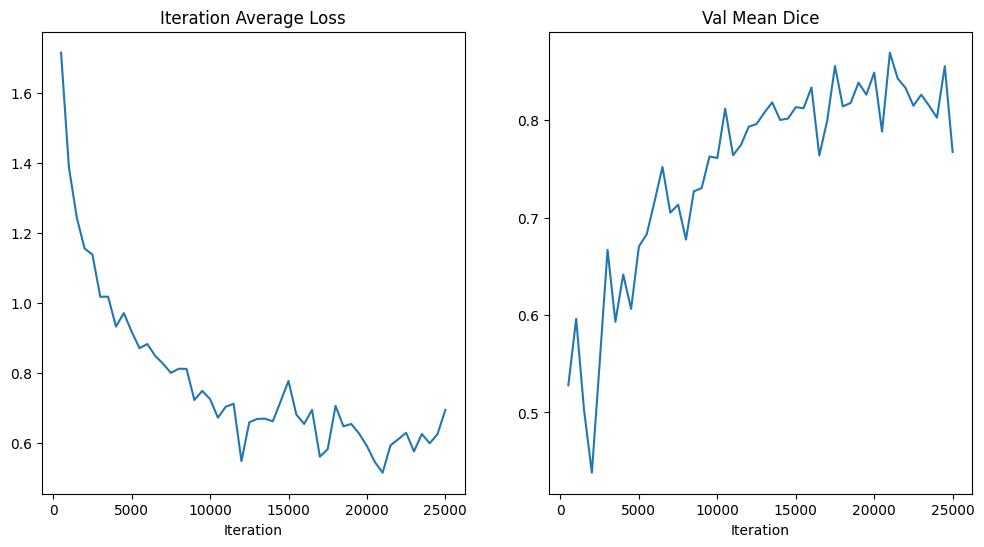

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "unetr_vittowavevit_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "unetr_vittowavevit_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.83708): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.66783): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (71 / 25000 Steps) (loss=2.60965): 100%|█| 24/24 [00:12<00:00,  1.93it/
Training (95 / 25000 Steps) (loss=2.62330): 100%|█| 24/24 [00:12<00:00,  1.96it/
Training (119 / 25000 Steps) (loss=2.50878): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (143 / 25000 Steps) (loss=2.44323): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (167 / 25000 Steps) (loss=2.49371): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (191 / 25000 Steps) (loss=2.42338): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (215 / 25000 Steps) (loss=2.36931): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (239 / 25000 Steps) (loss=2.41984): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (263 / 25000 Steps) (loss=2.41032): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (287 / 25000 Steps) (loss=2.36051): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4503602981567383 Current Avg. Dice: 0.4503602981567383


Training (503 / 25000 Steps) (loss=1.92510): 100%|█| 24/24 [00:17<00:00,  1.39it
Training (527 / 25000 Steps) (loss=1.96965): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (551 / 25000 Steps) (loss=1.93118): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (575 / 25000 Steps) (loss=2.02423): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (599 / 25000 Steps) (loss=2.05497): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (623 / 25000 Steps) (loss=1.94304): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (647 / 25000 Steps) (loss=1.90389): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (671 / 25000 Steps) (loss=1.88367): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (695 / 25000 Steps) (loss=1.82012): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (719 / 25000 Steps) (loss=1.88025): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (743 / 25000 Steps) (loss=1.85613): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (767 / 25000 Steps) (loss=1.60808): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.4503602981567383 Current Avg. Dice: 0.4010531008243561


Training (1007 / 25000 Steps) (loss=1.59743): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (1031 / 25000 Steps) (loss=1.56327): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.57871): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=1.50986): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1103 / 25000 Steps) (loss=1.38536): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1127 / 25000 Steps) (loss=1.41514): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1151 / 25000 Steps) (loss=1.49184): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1175 / 25000 Steps) (loss=1.54607): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1199 / 25000 Steps) (loss=1.40489): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1223 / 25000 Steps) (loss=1.43714): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1247 / 25000 Steps) (loss=1.46320): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1271 / 25000 Steps) (loss=1.37822): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4503602981567383 Current Avg. Dice: 0.3583587110042572


Training (1511 / 25000 Steps) (loss=1.19585): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (1535 / 25000 Steps) (loss=1.33033): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.26275): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1583 / 25000 Steps) (loss=1.57830): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1607 / 25000 Steps) (loss=1.43492): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1631 / 25000 Steps) (loss=1.23889): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1655 / 25000 Steps) (loss=1.40502): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1679 / 25000 Steps) (loss=1.17736): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1703 / 25000 Steps) (loss=1.52317): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1727 / 25000 Steps) (loss=1.32844): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1751 / 25000 Steps) (loss=1.15454): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1775 / 25000 Steps) (loss=1.24339): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4503602981567383 Current Avg. Dice: 0.39913153648376465


Training (2015 / 25000 Steps) (loss=1.22380): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (2039 / 25000 Steps) (loss=1.20749): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2063 / 25000 Steps) (loss=1.11480): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2087 / 25000 Steps) (loss=1.18337): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2111 / 25000 Steps) (loss=1.06719): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2135 / 25000 Steps) (loss=1.28038): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2159 / 25000 Steps) (loss=1.26956): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2183 / 25000 Steps) (loss=1.35185): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2207 / 25000 Steps) (loss=1.14294): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2231 / 25000 Steps) (loss=2.06170): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2255 / 25000 Steps) (loss=1.12270): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2279 / 25000 Steps) (loss=1.25126): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4503602981567383 Current Avg. Dice: 0.4024362564086914


Training (2519 / 25000 Steps) (loss=1.11938): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (2543 / 25000 Steps) (loss=1.13961): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2567 / 25000 Steps) (loss=1.14940): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2591 / 25000 Steps) (loss=1.09475): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2615 / 25000 Steps) (loss=1.06705): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2639 / 25000 Steps) (loss=0.99017): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2663 / 25000 Steps) (loss=1.10065): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2687 / 25000 Steps) (loss=1.26534): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2711 / 25000 Steps) (loss=1.01948): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2735 / 25000 Steps) (loss=1.09310): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2759 / 25000 Steps) (loss=1.31456): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2783 / 25000 Steps) (loss=1.09462): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5221483111381531 Current Avg. Dice: 0.5221483111381531


Training (3023 / 25000 Steps) (loss=1.22414): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (3047 / 25000 Steps) (loss=1.03335): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3071 / 25000 Steps) (loss=1.06699): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3095 / 25000 Steps) (loss=1.09722): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3119 / 25000 Steps) (loss=1.02216): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3143 / 25000 Steps) (loss=1.00181): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3167 / 25000 Steps) (loss=1.01466): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.13652): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3215 / 25000 Steps) (loss=1.12887): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3239 / 25000 Steps) (loss=1.17467): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3263 / 25000 Steps) (loss=1.18258): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3287 / 25000 Steps) (loss=1.05895): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5221483111381531 Current Avg. Dice: 0.4295499324798584


Training (3503 / 25000 Steps) (loss=0.97154): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3527 / 25000 Steps) (loss=1.08729): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3551 / 25000 Steps) (loss=1.01480): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3575 / 25000 Steps) (loss=0.98018): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3599 / 25000 Steps) (loss=1.04107): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3623 / 25000 Steps) (loss=1.02577): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=0.99151): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3671 / 25000 Steps) (loss=0.96676): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3695 / 25000 Steps) (loss=1.03019): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3719 / 25000 Steps) (loss=1.15162): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3743 / 25000 Steps) (loss=0.99895): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=0.94083): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5615518689155579 Current Avg. Dice: 0.5615518689155579


Training (4007 / 25000 Steps) (loss=0.96890): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (4031 / 25000 Steps) (loss=0.97623): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4055 / 25000 Steps) (loss=1.06032): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4079 / 25000 Steps) (loss=0.97717): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4103 / 25000 Steps) (loss=1.01724): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4127 / 25000 Steps) (loss=0.93814): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=1.02873): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4175 / 25000 Steps) (loss=1.05215): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4199 / 25000 Steps) (loss=0.91219): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4223 / 25000 Steps) (loss=1.01189): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4247 / 25000 Steps) (loss=0.87739): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4271 / 25000 Steps) (loss=1.14751): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5615518689155579 Current Avg. Dice: 0.5208253264427185


Training (4511 / 25000 Steps) (loss=0.91457): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (4535 / 25000 Steps) (loss=0.97653): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4559 / 25000 Steps) (loss=0.91639): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4583 / 25000 Steps) (loss=1.02867): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4607 / 25000 Steps) (loss=0.92720): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4631 / 25000 Steps) (loss=1.23219): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=0.91725): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4679 / 25000 Steps) (loss=0.90774): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4703 / 25000 Steps) (loss=1.01267): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4727 / 25000 Steps) (loss=0.93955): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4751 / 25000 Steps) (loss=0.87222): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4775 / 25000 Steps) (loss=1.01264): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5615518689155579 Current Avg. Dice: 0.49363622069358826


Training (5015 / 25000 Steps) (loss=0.85354): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5039 / 25000 Steps) (loss=1.10451): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5063 / 25000 Steps) (loss=0.95624): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5087 / 25000 Steps) (loss=0.96772): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5111 / 25000 Steps) (loss=1.05805): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5135 / 25000 Steps) (loss=0.92472): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5159 / 25000 Steps) (loss=0.94984): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5183 / 25000 Steps) (loss=1.21031): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5207 / 25000 Steps) (loss=0.94794): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5231 / 25000 Steps) (loss=0.90867): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5255 / 25000 Steps) (loss=0.99566): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5279 / 25000 Steps) (loss=0.86295): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5615518689155579 Current Avg. Dice: 0.551637589931488


Training (5519 / 25000 Steps) (loss=0.97737): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5543 / 25000 Steps) (loss=1.06112): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5567 / 25000 Steps) (loss=0.87791): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5591 / 25000 Steps) (loss=0.89556): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5615 / 25000 Steps) (loss=0.99541): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5639 / 25000 Steps) (loss=0.92914): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5663 / 25000 Steps) (loss=0.90636): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5687 / 25000 Steps) (loss=0.94054): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5711 / 25000 Steps) (loss=0.98944): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=0.90681): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5759 / 25000 Steps) (loss=0.80709): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5783 / 25000 Steps) (loss=0.88771): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5615518689155579 Current Avg. Dice: 0.5456640720367432


Training (6023 / 25000 Steps) (loss=0.86644): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (6047 / 25000 Steps) (loss=0.91349): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6071 / 25000 Steps) (loss=0.94385): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6095 / 25000 Steps) (loss=0.81801): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6119 / 25000 Steps) (loss=0.93179): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6143 / 25000 Steps) (loss=0.95969): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6167 / 25000 Steps) (loss=0.86379): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6191 / 25000 Steps) (loss=1.47673): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6215 / 25000 Steps) (loss=0.84726): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6239 / 25000 Steps) (loss=1.19316): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6263 / 25000 Steps) (loss=0.83966): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6287 / 25000 Steps) (loss=0.79395): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6532856225967407 Current Avg. Dice: 0.6532856225967407


Training (6503 / 25000 Steps) (loss=0.99759): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (6527 / 25000 Steps) (loss=0.90371): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6551 / 25000 Steps) (loss=0.81863): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=0.80010): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.91523): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6623 / 25000 Steps) (loss=0.94471): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6647 / 25000 Steps) (loss=1.11681): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6671 / 25000 Steps) (loss=1.20338): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6695 / 25000 Steps) (loss=0.82797): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6719 / 25000 Steps) (loss=0.99049): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6743 / 25000 Steps) (loss=0.90028): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.78437): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6532856225967407 Current Avg. Dice: 0.6012935638427734


Training (7007 / 25000 Steps) (loss=0.87369): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (7031 / 25000 Steps) (loss=0.68223): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7055 / 25000 Steps) (loss=0.84453): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7079 / 25000 Steps) (loss=0.90691): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7103 / 25000 Steps) (loss=0.84961): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7127 / 25000 Steps) (loss=0.76369): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7151 / 25000 Steps) (loss=0.92187): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7175 / 25000 Steps) (loss=1.02664): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7199 / 25000 Steps) (loss=0.81384): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7223 / 25000 Steps) (loss=0.94576): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7247 / 25000 Steps) (loss=0.71087): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7271 / 25000 Steps) (loss=0.89856): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6532856225967407 Current Avg. Dice: 0.6038753390312195


Training (7511 / 25000 Steps) (loss=1.29246): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7535 / 25000 Steps) (loss=1.31934): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7559 / 25000 Steps) (loss=0.79729): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7583 / 25000 Steps) (loss=0.94957): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7607 / 25000 Steps) (loss=0.77737): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7631 / 25000 Steps) (loss=0.83449): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7655 / 25000 Steps) (loss=0.86085): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7679 / 25000 Steps) (loss=0.87962): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7703 / 25000 Steps) (loss=0.80127): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7727 / 25000 Steps) (loss=0.90558): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7751 / 25000 Steps) (loss=0.78522): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7775 / 25000 Steps) (loss=0.88479): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6532856225967407 Current Avg. Dice: 0.6511083245277405


Training (8015 / 25000 Steps) (loss=0.72115): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8039 / 25000 Steps) (loss=0.84299): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8063 / 25000 Steps) (loss=0.84718): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8087 / 25000 Steps) (loss=0.91285): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8111 / 25000 Steps) (loss=0.75408): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8135 / 25000 Steps) (loss=0.80798): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8159 / 25000 Steps) (loss=0.84681): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8183 / 25000 Steps) (loss=0.84538): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.84579): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=0.80563): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8255 / 25000 Steps) (loss=0.67753): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8279 / 25000 Steps) (loss=0.66809): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7563636898994446 Current Avg. Dice: 0.7563636898994446


Training (8519 / 25000 Steps) (loss=0.77097): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (8543 / 25000 Steps) (loss=0.81851): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8567 / 25000 Steps) (loss=0.77149): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8591 / 25000 Steps) (loss=0.73897): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=0.76530): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8639 / 25000 Steps) (loss=0.83739): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8663 / 25000 Steps) (loss=0.78966): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8687 / 25000 Steps) (loss=0.96884): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8711 / 25000 Steps) (loss=0.73755): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=0.78000): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8759 / 25000 Steps) (loss=0.76753): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8783 / 25000 Steps) (loss=0.83410): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7563636898994446 Current Avg. Dice: 0.7479774355888367


Training (9023 / 25000 Steps) (loss=0.80494): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (9047 / 25000 Steps) (loss=0.79733): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9071 / 25000 Steps) (loss=0.72339): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9095 / 25000 Steps) (loss=0.67269): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9119 / 25000 Steps) (loss=0.92325): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.67667): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9167 / 25000 Steps) (loss=0.76847): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9191 / 25000 Steps) (loss=0.66364): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.82104): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9239 / 25000 Steps) (loss=0.78716): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9263 / 25000 Steps) (loss=0.71033): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9287 / 25000 Steps) (loss=0.76865): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7563636898994446 Current Avg. Dice: 0.7522761225700378


Training (9503 / 25000 Steps) (loss=0.77352): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9527 / 25000 Steps) (loss=0.79158): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9551 / 25000 Steps) (loss=0.82516): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.77405): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9599 / 25000 Steps) (loss=0.91210): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9623 / 25000 Steps) (loss=0.77785): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9647 / 25000 Steps) (loss=0.77927): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9671 / 25000 Steps) (loss=0.65495): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9695 / 25000 Steps) (loss=0.94066): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9719 / 25000 Steps) (loss=0.67374): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9743 / 25000 Steps) (loss=0.61984): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9767 / 25000 Steps) (loss=0.90508): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7563636898994446 Current Avg. Dice: 0.7425970435142517


Training (10007 / 25000 Steps) (loss=0.74651): 100%|█| 24/24 [00:13<00:00,  1.78
Training (10031 / 25000 Steps) (loss=0.77186): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10055 / 25000 Steps) (loss=0.71725): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10079 / 25000 Steps) (loss=0.68403): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.74076): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10127 / 25000 Steps) (loss=0.75019): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10151 / 25000 Steps) (loss=0.77386): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10175 / 25000 Steps) (loss=0.64543): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10199 / 25000 Steps) (loss=0.77842): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10223 / 25000 Steps) (loss=0.66965): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10247 / 25000 Steps) (loss=0.83539): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10271 / 25000 Steps) (loss=0.68658): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7618372440338135 Current Avg. Dice: 0.7618372440338135


Training (10511 / 25000 Steps) (loss=0.77627): 100%|█| 24/24 [00:16<00:00,  1.42
Training (10535 / 25000 Steps) (loss=0.69917): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.59755): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10583 / 25000 Steps) (loss=0.62836): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10607 / 25000 Steps) (loss=0.75604): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10631 / 25000 Steps) (loss=0.82936): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10655 / 25000 Steps) (loss=0.67920): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10679 / 25000 Steps) (loss=0.70917): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.63710): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10727 / 25000 Steps) (loss=0.68047): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10751 / 25000 Steps) (loss=0.97912): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10775 / 25000 Steps) (loss=0.89127): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618372440338135 Current Avg. Dice: 0.7516153454780579


Training (11015 / 25000 Steps) (loss=0.80083): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11039 / 25000 Steps) (loss=0.95132): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11063 / 25000 Steps) (loss=1.28550): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11087 / 25000 Steps) (loss=0.85905): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11111 / 25000 Steps) (loss=0.77978): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11135 / 25000 Steps) (loss=0.99619): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11159 / 25000 Steps) (loss=0.77883): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.73663): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11207 / 25000 Steps) (loss=0.55888): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11231 / 25000 Steps) (loss=0.74658): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11255 / 25000 Steps) (loss=0.78873): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11279 / 25000 Steps) (loss=0.89421): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618372440338135 Current Avg. Dice: 0.7321240305900574


Training (11519 / 25000 Steps) (loss=0.73533): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11543 / 25000 Steps) (loss=0.76808): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11567 / 25000 Steps) (loss=0.70568): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11591 / 25000 Steps) (loss=0.81987): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11615 / 25000 Steps) (loss=0.64125): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11639 / 25000 Steps) (loss=0.74542): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11663 / 25000 Steps) (loss=0.59107): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11687 / 25000 Steps) (loss=0.76951): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11711 / 25000 Steps) (loss=0.67396): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11735 / 25000 Steps) (loss=0.73954): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11759 / 25000 Steps) (loss=0.63795): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11783 / 25000 Steps) (loss=0.74457): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8376790881156921 Current Avg. Dice: 0.8376790881156921


Training (12023 / 25000 Steps) (loss=0.62566): 100%|█| 24/24 [00:17<00:00,  1.41
Training (12047 / 25000 Steps) (loss=0.67814): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12071 / 25000 Steps) (loss=0.80583): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12095 / 25000 Steps) (loss=0.79961): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12119 / 25000 Steps) (loss=0.54580): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12143 / 25000 Steps) (loss=0.51812): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12167 / 25000 Steps) (loss=0.82287): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12191 / 25000 Steps) (loss=0.77798): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12215 / 25000 Steps) (loss=0.76056): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12239 / 25000 Steps) (loss=0.55277): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12263 / 25000 Steps) (loss=0.56927): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12287 / 25000 Steps) (loss=0.58987): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8376790881156921 Current Avg. Dice: 0.8041859269142151


Training (12503 / 25000 Steps) (loss=0.63571): 100%|█| 24/24 [00:13<00:00,  1.79
Training (12527 / 25000 Steps) (loss=0.76557): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12551 / 25000 Steps) (loss=0.68290): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12575 / 25000 Steps) (loss=0.62272): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12599 / 25000 Steps) (loss=0.62897): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12623 / 25000 Steps) (loss=0.59812): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12647 / 25000 Steps) (loss=0.69642): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12671 / 25000 Steps) (loss=0.71840): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12695 / 25000 Steps) (loss=0.60262): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12719 / 25000 Steps) (loss=0.65197): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12743 / 25000 Steps) (loss=0.71599): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12767 / 25000 Steps) (loss=0.88935): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.8395485281944275


Training (13007 / 25000 Steps) (loss=0.69864): 100%|█| 24/24 [00:16<00:00,  1.42
Training (13031 / 25000 Steps) (loss=0.86668): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13055 / 25000 Steps) (loss=0.86677): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13079 / 25000 Steps) (loss=0.66900): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13103 / 25000 Steps) (loss=0.65984): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13127 / 25000 Steps) (loss=0.84154): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13151 / 25000 Steps) (loss=0.79290): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13175 / 25000 Steps) (loss=0.76227): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13199 / 25000 Steps) (loss=0.79924): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13223 / 25000 Steps) (loss=0.75026): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13247 / 25000 Steps) (loss=0.62213): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13271 / 25000 Steps) (loss=0.92817): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.7836103439331055


Training (13511 / 25000 Steps) (loss=0.56028): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13535 / 25000 Steps) (loss=0.59431): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.50873): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13583 / 25000 Steps) (loss=0.52529): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13607 / 25000 Steps) (loss=0.63043): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13631 / 25000 Steps) (loss=0.68549): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13655 / 25000 Steps) (loss=0.72232): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13679 / 25000 Steps) (loss=0.48514): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13703 / 25000 Steps) (loss=0.56425): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13727 / 25000 Steps) (loss=0.55011): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13751 / 25000 Steps) (loss=0.70887): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13775 / 25000 Steps) (loss=0.73512): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.7865936160087585


Training (14015 / 25000 Steps) (loss=0.79298): 100%|█| 24/24 [00:13<00:00,  1.76
Training (14039 / 25000 Steps) (loss=0.49525): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14063 / 25000 Steps) (loss=0.66047): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14087 / 25000 Steps) (loss=0.50523): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14111 / 25000 Steps) (loss=0.68104): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.55861): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14159 / 25000 Steps) (loss=0.54193): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14183 / 25000 Steps) (loss=0.71118): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14207 / 25000 Steps) (loss=0.65677): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14231 / 25000 Steps) (loss=0.66252): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14255 / 25000 Steps) (loss=0.70099): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14279 / 25000 Steps) (loss=0.88436): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.7667879462242126


Training (14519 / 25000 Steps) (loss=0.62779): 100%|█| 24/24 [00:13<00:00,  1.76
Training (14543 / 25000 Steps) (loss=0.59436): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14567 / 25000 Steps) (loss=0.69021): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.55679): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14615 / 25000 Steps) (loss=0.81154): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14639 / 25000 Steps) (loss=0.65892): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14663 / 25000 Steps) (loss=0.79819): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14687 / 25000 Steps) (loss=0.72818): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14711 / 25000 Steps) (loss=0.75240): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14735 / 25000 Steps) (loss=0.57572): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14759 / 25000 Steps) (loss=0.58198): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14783 / 25000 Steps) (loss=0.71428): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.7759106159210205


Training (15023 / 25000 Steps) (loss=0.63055): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15047 / 25000 Steps) (loss=0.73161): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15071 / 25000 Steps) (loss=0.66706): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15095 / 25000 Steps) (loss=0.74147): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15119 / 25000 Steps) (loss=0.61162): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15143 / 25000 Steps) (loss=0.65744): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15167 / 25000 Steps) (loss=0.62253): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15191 / 25000 Steps) (loss=0.68153): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15215 / 25000 Steps) (loss=0.66527): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15239 / 25000 Steps) (loss=0.69691): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15263 / 25000 Steps) (loss=0.56000): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15287 / 25000 Steps) (loss=0.87963): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8395485281944275 Current Avg. Dice: 0.8314240574836731


Training (15503 / 25000 Steps) (loss=0.50589): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15527 / 25000 Steps) (loss=0.56391): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15551 / 25000 Steps) (loss=0.50999): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15575 / 25000 Steps) (loss=0.62683): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15599 / 25000 Steps) (loss=0.63735): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15623 / 25000 Steps) (loss=0.66646): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15647 / 25000 Steps) (loss=0.54561): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15671 / 25000 Steps) (loss=0.73977): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15695 / 25000 Steps) (loss=0.68443): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15719 / 25000 Steps) (loss=0.79231): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15743 / 25000 Steps) (loss=0.63894): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15767 / 25000 Steps) (loss=0.58607): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.8655452728271484


Training (16007 / 25000 Steps) (loss=0.53060): 100%|█| 24/24 [00:17<00:00,  1.41
Training (16031 / 25000 Steps) (loss=0.66951): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16055 / 25000 Steps) (loss=0.76541): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16079 / 25000 Steps) (loss=0.58772): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16103 / 25000 Steps) (loss=0.58114): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16127 / 25000 Steps) (loss=0.55096): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16151 / 25000 Steps) (loss=0.75169): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.80255): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16199 / 25000 Steps) (loss=0.71365): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16223 / 25000 Steps) (loss=0.74289): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.62043): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16271 / 25000 Steps) (loss=0.64683): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7990571856498718


Training (16511 / 25000 Steps) (loss=0.76273): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.55123): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16559 / 25000 Steps) (loss=0.45891): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16583 / 25000 Steps) (loss=0.66194): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.62834): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16631 / 25000 Steps) (loss=0.49173): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16655 / 25000 Steps) (loss=0.90138): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16679 / 25000 Steps) (loss=0.54765): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16703 / 25000 Steps) (loss=0.69493): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16727 / 25000 Steps) (loss=0.69069): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16751 / 25000 Steps) (loss=0.83977): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.70256): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7724388241767883


Training (17015 / 25000 Steps) (loss=0.75784): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17039 / 25000 Steps) (loss=0.60671): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17063 / 25000 Steps) (loss=0.70085): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17087 / 25000 Steps) (loss=0.65453): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17111 / 25000 Steps) (loss=0.79367): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17135 / 25000 Steps) (loss=0.62446): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.55094): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17183 / 25000 Steps) (loss=0.68983): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17207 / 25000 Steps) (loss=0.59962): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17231 / 25000 Steps) (loss=0.61969): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17255 / 25000 Steps) (loss=0.63162): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17279 / 25000 Steps) (loss=0.59613): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7676186561584473


Training (17519 / 25000 Steps) (loss=0.63931): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17543 / 25000 Steps) (loss=0.68728): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17567 / 25000 Steps) (loss=0.51691): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17591 / 25000 Steps) (loss=0.49329): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17615 / 25000 Steps) (loss=0.74367): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17639 / 25000 Steps) (loss=0.65324): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17663 / 25000 Steps) (loss=0.55722): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17687 / 25000 Steps) (loss=0.64287): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17711 / 25000 Steps) (loss=0.53343): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17735 / 25000 Steps) (loss=0.64761): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17759 / 25000 Steps) (loss=0.75723): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17783 / 25000 Steps) (loss=0.58229): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.795146644115448


Training (18023 / 25000 Steps) (loss=0.57225): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18047 / 25000 Steps) (loss=0.48411): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18071 / 25000 Steps) (loss=0.66918): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18095 / 25000 Steps) (loss=0.71821): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18119 / 25000 Steps) (loss=0.60334): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18143 / 25000 Steps) (loss=0.44823): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18167 / 25000 Steps) (loss=0.60897): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18191 / 25000 Steps) (loss=0.79378): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18215 / 25000 Steps) (loss=0.60878): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18239 / 25000 Steps) (loss=0.74340): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18263 / 25000 Steps) (loss=0.66589): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18287 / 25000 Steps) (loss=0.59267): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7562861442565918


Training (18503 / 25000 Steps) (loss=0.60155): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18527 / 25000 Steps) (loss=0.65357): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18551 / 25000 Steps) (loss=0.54599): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18575 / 25000 Steps) (loss=0.57634): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18599 / 25000 Steps) (loss=0.69337): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18623 / 25000 Steps) (loss=0.58294): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18647 / 25000 Steps) (loss=0.58222): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18671 / 25000 Steps) (loss=0.51345): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18695 / 25000 Steps) (loss=0.68952): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18719 / 25000 Steps) (loss=0.56905): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18743 / 25000 Steps) (loss=0.61294): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18767 / 25000 Steps) (loss=0.72790): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.8418857455253601


Training (19007 / 25000 Steps) (loss=0.62003): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19031 / 25000 Steps) (loss=0.54776): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19055 / 25000 Steps) (loss=0.62872): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19079 / 25000 Steps) (loss=0.72174): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19103 / 25000 Steps) (loss=0.55835): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19127 / 25000 Steps) (loss=0.55566): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.62751): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19175 / 25000 Steps) (loss=0.62485): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19199 / 25000 Steps) (loss=0.72495): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19223 / 25000 Steps) (loss=0.58666): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19247 / 25000 Steps) (loss=0.82175): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19271 / 25000 Steps) (loss=0.59215): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7646398544311523


Training (19511 / 25000 Steps) (loss=0.60084): 100%|█| 24/24 [00:13<00:00,  1.79
Training (19535 / 25000 Steps) (loss=0.65113): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19559 / 25000 Steps) (loss=0.65778): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19583 / 25000 Steps) (loss=0.67116): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19607 / 25000 Steps) (loss=0.45607): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.60953): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19655 / 25000 Steps) (loss=0.70277): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19679 / 25000 Steps) (loss=0.76473): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19703 / 25000 Steps) (loss=0.67985): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19727 / 25000 Steps) (loss=0.58580): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.74681): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19775 / 25000 Steps) (loss=0.61388): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7603679299354553


Training (20015 / 25000 Steps) (loss=0.55045): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.57539): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20063 / 25000 Steps) (loss=0.68621): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20087 / 25000 Steps) (loss=0.52576): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20111 / 25000 Steps) (loss=0.70469): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20135 / 25000 Steps) (loss=0.59706): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20159 / 25000 Steps) (loss=0.61327): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=1.02313): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20207 / 25000 Steps) (loss=0.84247): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20231 / 25000 Steps) (loss=0.49204): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.48948): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.68229): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7779446244239807


Training (20519 / 25000 Steps) (loss=0.67949): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20543 / 25000 Steps) (loss=0.66976): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20567 / 25000 Steps) (loss=0.67753): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20591 / 25000 Steps) (loss=0.62074): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20615 / 25000 Steps) (loss=0.72923): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20639 / 25000 Steps) (loss=0.70662): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.81192): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20687 / 25000 Steps) (loss=0.91827): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20711 / 25000 Steps) (loss=0.53419): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.68872): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.62677): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20783 / 25000 Steps) (loss=0.51873): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7849655747413635


Training (21023 / 25000 Steps) (loss=0.68427): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21047 / 25000 Steps) (loss=0.59569): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21071 / 25000 Steps) (loss=0.67433): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21095 / 25000 Steps) (loss=0.76741): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.77394): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.58271): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21167 / 25000 Steps) (loss=0.63365): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21191 / 25000 Steps) (loss=0.53674): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21215 / 25000 Steps) (loss=0.84762): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21239 / 25000 Steps) (loss=0.68572): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21263 / 25000 Steps) (loss=0.63272): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21287 / 25000 Steps) (loss=0.64624): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.823084831237793


Training (21503 / 25000 Steps) (loss=1.08082): 100%|█| 24/24 [00:13<00:00,  1.78
Training (21527 / 25000 Steps) (loss=0.47892): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.55133): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21575 / 25000 Steps) (loss=0.61393): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21599 / 25000 Steps) (loss=0.47972): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21623 / 25000 Steps) (loss=0.73590): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21647 / 25000 Steps) (loss=0.48716): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21671 / 25000 Steps) (loss=0.65574): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.60972): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21719 / 25000 Steps) (loss=0.51941): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.57339): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21767 / 25000 Steps) (loss=0.68061): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.8258552551269531


Training (22007 / 25000 Steps) (loss=0.71138): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22031 / 25000 Steps) (loss=0.65524): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22055 / 25000 Steps) (loss=0.76092): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22079 / 25000 Steps) (loss=0.58364): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22103 / 25000 Steps) (loss=0.72688): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22127 / 25000 Steps) (loss=0.46308): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22151 / 25000 Steps) (loss=0.57194): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22175 / 25000 Steps) (loss=0.70404): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.56481): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22223 / 25000 Steps) (loss=0.53716): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22247 / 25000 Steps) (loss=0.55900): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.73976): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7611064910888672


Training (22511 / 25000 Steps) (loss=0.56484): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22535 / 25000 Steps) (loss=0.69011): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22559 / 25000 Steps) (loss=0.60747): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22583 / 25000 Steps) (loss=0.57223): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22607 / 25000 Steps) (loss=0.80351): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22631 / 25000 Steps) (loss=0.49325): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22655 / 25000 Steps) (loss=0.89135): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22679 / 25000 Steps) (loss=0.64444): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22703 / 25000 Steps) (loss=0.59078): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22727 / 25000 Steps) (loss=0.64205): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22751 / 25000 Steps) (loss=0.64427): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22775 / 25000 Steps) (loss=0.67061): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7959211468696594


Training (23015 / 25000 Steps) (loss=0.47791): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23039 / 25000 Steps) (loss=0.55666): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23063 / 25000 Steps) (loss=0.70994): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23087 / 25000 Steps) (loss=0.53441): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23111 / 25000 Steps) (loss=0.67720): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23135 / 25000 Steps) (loss=0.76179): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23159 / 25000 Steps) (loss=0.62626): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.73810): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23207 / 25000 Steps) (loss=0.71707): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23231 / 25000 Steps) (loss=0.64322): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23255 / 25000 Steps) (loss=0.56322): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23279 / 25000 Steps) (loss=0.63455): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.792529284954071


Training (23519 / 25000 Steps) (loss=0.67235): 100%|█| 24/24 [00:13<00:00,  1.80
Training (23543 / 25000 Steps) (loss=0.71594): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23567 / 25000 Steps) (loss=0.51289): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23591 / 25000 Steps) (loss=0.75137): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23615 / 25000 Steps) (loss=0.59320): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23639 / 25000 Steps) (loss=0.66141): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23663 / 25000 Steps) (loss=0.71708): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23687 / 25000 Steps) (loss=0.49052): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23711 / 25000 Steps) (loss=0.67805): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23735 / 25000 Steps) (loss=0.65728): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23759 / 25000 Steps) (loss=0.50262): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23783 / 25000 Steps) (loss=0.77434): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7970879673957825


Training (24023 / 25000 Steps) (loss=0.73199): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.66472): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24071 / 25000 Steps) (loss=0.52478): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24095 / 25000 Steps) (loss=0.57180): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24119 / 25000 Steps) (loss=0.50518): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24143 / 25000 Steps) (loss=0.70627): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24167 / 25000 Steps) (loss=0.58764): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24191 / 25000 Steps) (loss=0.75269): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24215 / 25000 Steps) (loss=0.67628): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24239 / 25000 Steps) (loss=0.50295): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24263 / 25000 Steps) (loss=0.56668): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24287 / 25000 Steps) (loss=0.54735): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.8079372048377991


Training (24503 / 25000 Steps) (loss=0.35165): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24527 / 25000 Steps) (loss=0.56432): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.50268): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24575 / 25000 Steps) (loss=0.51243): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.62230): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24623 / 25000 Steps) (loss=0.37755): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24647 / 25000 Steps) (loss=0.49786): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.74306): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24695 / 25000 Steps) (loss=0.59869): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24719 / 25000 Steps) (loss=0.51861): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.83055): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24767 / 25000 Steps) (loss=0.51365): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8655452728271484 Current Avg. Dice: 0.7852689623832703


Training (25007 / 25000 Steps) (loss=0.68640): 100%|█| 24/24 [00:13<00:00,  1.79


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8655 at iteration: 16000


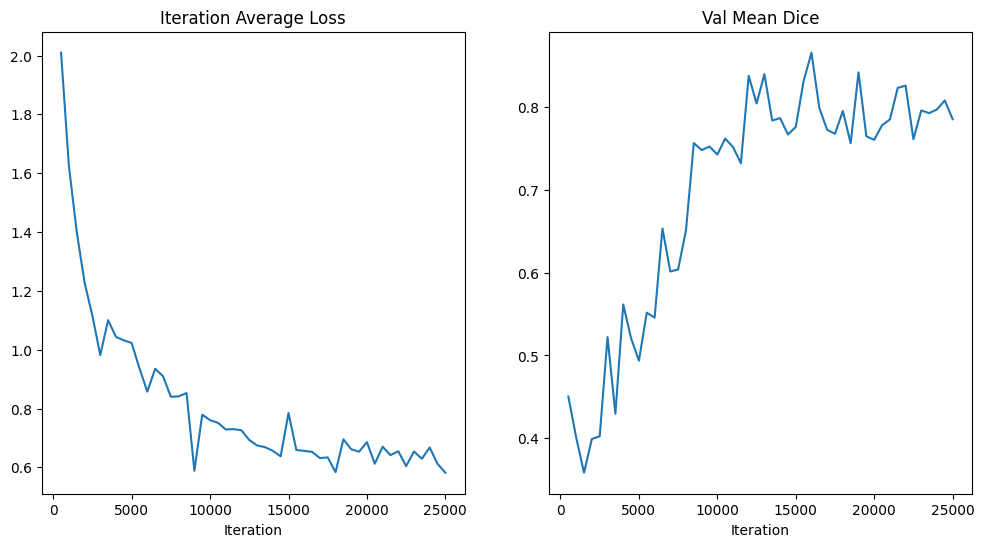

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.28it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.90022): 100%|█| 24/24 [00:14<00:00,  1.63it/
Training (47 / 25000 Steps) (loss=2.71944): 100%|█| 24/24 [00:12<00:00,  2.00it/
Training (71 / 25000 Steps) (loss=2.62168): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (95 / 25000 Steps) (loss=2.54103): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (119 / 25000 Steps) (loss=2.48208): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (143 / 25000 Steps) (loss=2.44853): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (167 / 25000 Steps) (loss=2.37078): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (191 / 25000 Steps) (loss=2.36621): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (215 / 25000 Steps) (loss=2.35504): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (239 / 25000 Steps) (loss=2.29061): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (263 / 25000 Steps) (loss=2.32087): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (287 / 25000 Steps) (loss=2.25365): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4543739855289459 Current Avg. Dice: 0.4543739855289459


Training (503 / 25000 Steps) (loss=2.06129): 100%|█| 24/24 [00:17<00:00,  1.41it
Training (527 / 25000 Steps) (loss=1.97847): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (551 / 25000 Steps) (loss=1.96390): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (575 / 25000 Steps) (loss=1.85335): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (599 / 25000 Steps) (loss=1.87353): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (623 / 25000 Steps) (loss=1.99981): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=1.92034): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (671 / 25000 Steps) (loss=1.84115): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (695 / 25000 Steps) (loss=1.83447): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (719 / 25000 Steps) (loss=1.87588): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (743 / 25000 Steps) (loss=1.77507): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (767 / 25000 Steps) (loss=1.73109): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.4543739855289459 Current Avg. Dice: 0.38483676314353943


Training (1007 / 25000 Steps) (loss=1.69718): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (1031 / 25000 Steps) (loss=1.55903): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1055 / 25000 Steps) (loss=1.57069): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1079 / 25000 Steps) (loss=1.60920): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1103 / 25000 Steps) (loss=1.66226): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1127 / 25000 Steps) (loss=1.58782): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1151 / 25000 Steps) (loss=1.37529): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (1175 / 25000 Steps) (loss=1.42366): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.58484): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1223 / 25000 Steps) (loss=1.54538): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1247 / 25000 Steps) (loss=1.48577): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1271 / 25000 Steps) (loss=1.37955): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4725460112094879 Current Avg. Dice: 0.4725460112094879


Training (1511 / 25000 Steps) (loss=1.32917): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (1535 / 25000 Steps) (loss=1.34512): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1559 / 25000 Steps) (loss=1.32931): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.27571): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1607 / 25000 Steps) (loss=1.21269): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.40066): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.31180): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1679 / 25000 Steps) (loss=1.21265): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1703 / 25000 Steps) (loss=1.15472): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1727 / 25000 Steps) (loss=1.31513): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1751 / 25000 Steps) (loss=1.32926): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1775 / 25000 Steps) (loss=1.24625): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4725460112094879 Current Avg. Dice: 0.4715735614299774


Training (2015 / 25000 Steps) (loss=1.25917): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2039 / 25000 Steps) (loss=1.19627): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2063 / 25000 Steps) (loss=1.23249): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2087 / 25000 Steps) (loss=1.44548): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2111 / 25000 Steps) (loss=1.12839): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2135 / 25000 Steps) (loss=1.16192): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2159 / 25000 Steps) (loss=1.19556): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2183 / 25000 Steps) (loss=1.09145): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2207 / 25000 Steps) (loss=1.16567): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2231 / 25000 Steps) (loss=1.22426): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2255 / 25000 Steps) (loss=1.16192): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2279 / 25000 Steps) (loss=1.13399): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4725460112094879 Current Avg. Dice: 0.46633031964302063


Training (2519 / 25000 Steps) (loss=1.02970): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2543 / 25000 Steps) (loss=1.47316): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2567 / 25000 Steps) (loss=1.64215): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2591 / 25000 Steps) (loss=1.17323): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2615 / 25000 Steps) (loss=1.14634): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2639 / 25000 Steps) (loss=1.03778): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2663 / 25000 Steps) (loss=1.23956): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2687 / 25000 Steps) (loss=1.13479): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2711 / 25000 Steps) (loss=1.57598): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2735 / 25000 Steps) (loss=1.21906): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2759 / 25000 Steps) (loss=1.11521): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2783 / 25000 Steps) (loss=1.05396): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5886995196342468 Current Avg. Dice: 0.5886995196342468


Training (3023 / 25000 Steps) (loss=1.04872): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (3047 / 25000 Steps) (loss=1.08432): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3071 / 25000 Steps) (loss=1.10499): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3095 / 25000 Steps) (loss=0.93944): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3119 / 25000 Steps) (loss=0.99152): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3143 / 25000 Steps) (loss=1.10124): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3167 / 25000 Steps) (loss=1.04755): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3191 / 25000 Steps) (loss=1.00775): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3215 / 25000 Steps) (loss=1.32385): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3239 / 25000 Steps) (loss=0.95243): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3263 / 25000 Steps) (loss=1.06019): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3287 / 25000 Steps) (loss=1.04584): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5886995196342468 Current Avg. Dice: 0.582034170627594


Training (3503 / 25000 Steps) (loss=0.98722): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (3527 / 25000 Steps) (loss=1.06753): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3551 / 25000 Steps) (loss=1.01711): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3575 / 25000 Steps) (loss=1.04379): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3599 / 25000 Steps) (loss=1.09624): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.00739): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3647 / 25000 Steps) (loss=0.88189): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3671 / 25000 Steps) (loss=1.03851): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3695 / 25000 Steps) (loss=1.24640): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3719 / 25000 Steps) (loss=0.90716): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3743 / 25000 Steps) (loss=1.01604): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=1.04444): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6094043850898743 Current Avg. Dice: 0.6094043850898743


Training (4007 / 25000 Steps) (loss=0.96317): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (4031 / 25000 Steps) (loss=1.05338): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4055 / 25000 Steps) (loss=0.90145): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4079 / 25000 Steps) (loss=1.81846): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4103 / 25000 Steps) (loss=0.98894): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4127 / 25000 Steps) (loss=1.06314): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4151 / 25000 Steps) (loss=0.97194): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4175 / 25000 Steps) (loss=0.93231): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4199 / 25000 Steps) (loss=0.84716): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4223 / 25000 Steps) (loss=0.85571): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4247 / 25000 Steps) (loss=1.04013): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4271 / 25000 Steps) (loss=0.87931): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6094043850898743 Current Avg. Dice: 0.5572940707206726


Training (4511 / 25000 Steps) (loss=1.01132): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (4535 / 25000 Steps) (loss=0.88390): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4559 / 25000 Steps) (loss=1.06118): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4583 / 25000 Steps) (loss=0.89788): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4607 / 25000 Steps) (loss=0.86261): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4631 / 25000 Steps) (loss=1.10439): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4655 / 25000 Steps) (loss=1.03857): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4679 / 25000 Steps) (loss=0.91984): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4703 / 25000 Steps) (loss=0.99703): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4727 / 25000 Steps) (loss=1.01711): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4751 / 25000 Steps) (loss=0.92962): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4775 / 25000 Steps) (loss=0.91364): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6835711002349854 Current Avg. Dice: 0.6835711002349854


Training (5015 / 25000 Steps) (loss=1.03624): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (5039 / 25000 Steps) (loss=0.81544): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5063 / 25000 Steps) (loss=0.93078): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5087 / 25000 Steps) (loss=0.77685): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5111 / 25000 Steps) (loss=0.85968): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5135 / 25000 Steps) (loss=0.86792): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.87816): 100%|█| 24/24 [00:11<00:00,  2.04i
Training (5183 / 25000 Steps) (loss=1.01890): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5207 / 25000 Steps) (loss=0.91047): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5231 / 25000 Steps) (loss=0.80542): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5255 / 25000 Steps) (loss=0.87858): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5279 / 25000 Steps) (loss=0.97364): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6835711002349854 Current Avg. Dice: 0.670372724533081


Training (5519 / 25000 Steps) (loss=0.85361): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5543 / 25000 Steps) (loss=0.81582): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5567 / 25000 Steps) (loss=0.93365): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5591 / 25000 Steps) (loss=0.82268): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5615 / 25000 Steps) (loss=1.03964): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5639 / 25000 Steps) (loss=0.89690): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5663 / 25000 Steps) (loss=0.77849): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5687 / 25000 Steps) (loss=0.77534): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5711 / 25000 Steps) (loss=0.85654): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5735 / 25000 Steps) (loss=0.90713): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5759 / 25000 Steps) (loss=0.94172): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5783 / 25000 Steps) (loss=1.08764): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6835711002349854 Current Avg. Dice: 0.6028627157211304


Training (6023 / 25000 Steps) (loss=0.80326): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6047 / 25000 Steps) (loss=0.74670): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6071 / 25000 Steps) (loss=0.79958): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6095 / 25000 Steps) (loss=0.89301): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6119 / 25000 Steps) (loss=0.97598): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6143 / 25000 Steps) (loss=0.73551): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6167 / 25000 Steps) (loss=0.92491): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6191 / 25000 Steps) (loss=0.90702): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6215 / 25000 Steps) (loss=0.83925): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6239 / 25000 Steps) (loss=0.82618): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6263 / 25000 Steps) (loss=0.95069): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6287 / 25000 Steps) (loss=0.98772): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6867637038230896 Current Avg. Dice: 0.6867637038230896


Training (6503 / 25000 Steps) (loss=0.92382): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6527 / 25000 Steps) (loss=0.87620): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6551 / 25000 Steps) (loss=0.83268): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6575 / 25000 Steps) (loss=0.85375): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.81714): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6623 / 25000 Steps) (loss=0.81220): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6647 / 25000 Steps) (loss=0.80759): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6671 / 25000 Steps) (loss=0.79824): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6695 / 25000 Steps) (loss=0.87225): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6719 / 25000 Steps) (loss=0.83168): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6743 / 25000 Steps) (loss=0.80216): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.68233): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7141491770744324 Current Avg. Dice: 0.7141491770744324


Training (7007 / 25000 Steps) (loss=1.24480): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (7031 / 25000 Steps) (loss=0.82124): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7055 / 25000 Steps) (loss=0.82341): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7079 / 25000 Steps) (loss=0.75700): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7103 / 25000 Steps) (loss=0.73723): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7127 / 25000 Steps) (loss=0.81210): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7151 / 25000 Steps) (loss=0.78670): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7175 / 25000 Steps) (loss=1.05228): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7199 / 25000 Steps) (loss=0.65067): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7223 / 25000 Steps) (loss=0.76275): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7247 / 25000 Steps) (loss=0.69544): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7271 / 25000 Steps) (loss=0.80453): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7141491770744324 Current Avg. Dice: 0.6592947840690613


Training (7511 / 25000 Steps) (loss=0.77309): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7535 / 25000 Steps) (loss=0.78785): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7559 / 25000 Steps) (loss=0.72670): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7583 / 25000 Steps) (loss=0.60108): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7607 / 25000 Steps) (loss=0.73212): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7631 / 25000 Steps) (loss=0.87068): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7655 / 25000 Steps) (loss=0.89988): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7679 / 25000 Steps) (loss=0.78625): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7703 / 25000 Steps) (loss=0.67387): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7727 / 25000 Steps) (loss=0.92878): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7751 / 25000 Steps) (loss=0.62875): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7775 / 25000 Steps) (loss=0.96741): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.7630386352539062


Training (8015 / 25000 Steps) (loss=0.78966): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (8039 / 25000 Steps) (loss=0.75619): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8063 / 25000 Steps) (loss=0.79321): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8087 / 25000 Steps) (loss=0.66834): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8111 / 25000 Steps) (loss=0.89835): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8135 / 25000 Steps) (loss=0.80739): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8159 / 25000 Steps) (loss=0.75396): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=0.63433): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.78116): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=0.74348): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8255 / 25000 Steps) (loss=0.87194): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8279 / 25000 Steps) (loss=0.78091): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.6454363465309143


Training (8519 / 25000 Steps) (loss=0.77311): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (8543 / 25000 Steps) (loss=0.75203): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8567 / 25000 Steps) (loss=0.92884): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8591 / 25000 Steps) (loss=0.78320): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=0.70410): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8639 / 25000 Steps) (loss=0.76389): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8663 / 25000 Steps) (loss=0.69904): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8687 / 25000 Steps) (loss=0.62949): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8711 / 25000 Steps) (loss=0.78898): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8735 / 25000 Steps) (loss=0.63360): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8759 / 25000 Steps) (loss=0.71072): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.70566): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.7125924229621887


Training (9023 / 25000 Steps) (loss=0.83889): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (9047 / 25000 Steps) (loss=0.70863): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9071 / 25000 Steps) (loss=0.66452): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9095 / 25000 Steps) (loss=0.78553): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9119 / 25000 Steps) (loss=0.68536): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9143 / 25000 Steps) (loss=0.58513): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9167 / 25000 Steps) (loss=0.78244): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9191 / 25000 Steps) (loss=0.60856): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.53261): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9239 / 25000 Steps) (loss=0.82687): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9263 / 25000 Steps) (loss=0.94861): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9287 / 25000 Steps) (loss=0.54880): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.6917886137962341


Training (9503 / 25000 Steps) (loss=0.75297): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (9527 / 25000 Steps) (loss=0.65153): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9551 / 25000 Steps) (loss=0.65971): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.63629): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9599 / 25000 Steps) (loss=0.79260): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9623 / 25000 Steps) (loss=0.99615): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9647 / 25000 Steps) (loss=0.75160): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9671 / 25000 Steps) (loss=0.69915): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9695 / 25000 Steps) (loss=0.55964): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9719 / 25000 Steps) (loss=1.10996): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9743 / 25000 Steps) (loss=0.66854): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9767 / 25000 Steps) (loss=0.69343): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.6579039096832275


Training (10007 / 25000 Steps) (loss=0.63551): 100%|█| 24/24 [00:13<00:00,  1.79
Training (10031 / 25000 Steps) (loss=0.54919): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10055 / 25000 Steps) (loss=0.78768): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10079 / 25000 Steps) (loss=0.67417): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.61563): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10127 / 25000 Steps) (loss=0.78837): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10151 / 25000 Steps) (loss=0.71518): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10175 / 25000 Steps) (loss=0.70700): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.80759): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10223 / 25000 Steps) (loss=0.63821): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10247 / 25000 Steps) (loss=0.51059): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.67727): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7630386352539062 Current Avg. Dice: 0.7257253527641296


Training (10511 / 25000 Steps) (loss=0.78857): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10535 / 25000 Steps) (loss=0.65735): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.77438): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10583 / 25000 Steps) (loss=0.66454): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10607 / 25000 Steps) (loss=0.70321): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10631 / 25000 Steps) (loss=0.63192): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10655 / 25000 Steps) (loss=0.63674): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10679 / 25000 Steps) (loss=0.65028): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.70699): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10727 / 25000 Steps) (loss=0.50667): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.64713): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10775 / 25000 Steps) (loss=0.73558): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.7735826969146729


Training (11015 / 25000 Steps) (loss=0.56935): 100%|█| 24/24 [00:16<00:00,  1.41
Training (11039 / 25000 Steps) (loss=0.74956): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11063 / 25000 Steps) (loss=0.71927): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11087 / 25000 Steps) (loss=0.57166): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11111 / 25000 Steps) (loss=0.71512): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11135 / 25000 Steps) (loss=0.62476): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11159 / 25000 Steps) (loss=0.72842): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.69749): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11207 / 25000 Steps) (loss=0.62994): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11231 / 25000 Steps) (loss=0.61678): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11255 / 25000 Steps) (loss=0.79853): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11279 / 25000 Steps) (loss=0.59970): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.6915760040283203


Training (11519 / 25000 Steps) (loss=0.68781): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11543 / 25000 Steps) (loss=0.59878): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11567 / 25000 Steps) (loss=0.92433): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11591 / 25000 Steps) (loss=0.76362): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11615 / 25000 Steps) (loss=0.64647): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11639 / 25000 Steps) (loss=0.68224): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11663 / 25000 Steps) (loss=0.73453): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11687 / 25000 Steps) (loss=0.57798): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11711 / 25000 Steps) (loss=0.73618): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11735 / 25000 Steps) (loss=0.64652): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11759 / 25000 Steps) (loss=0.64720): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11783 / 25000 Steps) (loss=0.63329): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.7054484486579895


Training (12023 / 25000 Steps) (loss=0.73029): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12047 / 25000 Steps) (loss=0.60693): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12071 / 25000 Steps) (loss=0.76630): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12095 / 25000 Steps) (loss=0.77683): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12119 / 25000 Steps) (loss=0.93846): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12143 / 25000 Steps) (loss=0.70837): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12167 / 25000 Steps) (loss=0.68117): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12191 / 25000 Steps) (loss=0.71929): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12215 / 25000 Steps) (loss=0.68344): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12239 / 25000 Steps) (loss=0.71205): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12263 / 25000 Steps) (loss=0.85346): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12287 / 25000 Steps) (loss=0.61566): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.7200856804847717


Training (12503 / 25000 Steps) (loss=0.68340): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12527 / 25000 Steps) (loss=0.74876): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12551 / 25000 Steps) (loss=0.64643): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12575 / 25000 Steps) (loss=0.71604): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12599 / 25000 Steps) (loss=0.61770): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12623 / 25000 Steps) (loss=0.46234): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12647 / 25000 Steps) (loss=0.51862): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12671 / 25000 Steps) (loss=0.76992): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12695 / 25000 Steps) (loss=0.73424): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12719 / 25000 Steps) (loss=0.66203): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12743 / 25000 Steps) (loss=0.79892): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12767 / 25000 Steps) (loss=0.67136): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.6854658126831055


Training (13007 / 25000 Steps) (loss=0.54879): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13031 / 25000 Steps) (loss=0.60887): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13055 / 25000 Steps) (loss=0.68425): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13079 / 25000 Steps) (loss=0.57411): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13103 / 25000 Steps) (loss=0.44956): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13127 / 25000 Steps) (loss=0.60315): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13151 / 25000 Steps) (loss=0.79532): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13175 / 25000 Steps) (loss=0.47550): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13199 / 25000 Steps) (loss=0.50492): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13223 / 25000 Steps) (loss=0.80971): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13247 / 25000 Steps) (loss=0.62667): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13271 / 25000 Steps) (loss=0.85678): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.7531876564025879


Training (13511 / 25000 Steps) (loss=0.56586): 100%|█| 24/24 [00:13<00:00,  1.79
Training (13535 / 25000 Steps) (loss=0.75619): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13559 / 25000 Steps) (loss=1.02662): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13583 / 25000 Steps) (loss=0.74367): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13607 / 25000 Steps) (loss=0.64390): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13631 / 25000 Steps) (loss=0.70360): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13655 / 25000 Steps) (loss=0.78821): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13679 / 25000 Steps) (loss=0.68077): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13703 / 25000 Steps) (loss=0.51140): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13727 / 25000 Steps) (loss=0.91872): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13751 / 25000 Steps) (loss=0.59311): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13775 / 25000 Steps) (loss=0.84375): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7735826969146729 Current Avg. Dice: 0.7533084750175476


Training (14015 / 25000 Steps) (loss=0.81772): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14039 / 25000 Steps) (loss=0.78719): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14063 / 25000 Steps) (loss=0.85207): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14087 / 25000 Steps) (loss=0.69475): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14111 / 25000 Steps) (loss=0.79286): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14135 / 25000 Steps) (loss=0.59823): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14159 / 25000 Steps) (loss=0.56712): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14183 / 25000 Steps) (loss=0.65481): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14207 / 25000 Steps) (loss=0.49534): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14231 / 25000 Steps) (loss=0.67675): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14255 / 25000 Steps) (loss=0.61829): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14279 / 25000 Steps) (loss=0.54647): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7981646656990051 Current Avg. Dice: 0.7981646656990051


Training (14519 / 25000 Steps) (loss=0.65362): 100%|█| 24/24 [00:17<00:00,  1.41
Training (14543 / 25000 Steps) (loss=0.65490): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14567 / 25000 Steps) (loss=0.69274): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14591 / 25000 Steps) (loss=0.70545): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14615 / 25000 Steps) (loss=0.62408): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14639 / 25000 Steps) (loss=0.58964): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14663 / 25000 Steps) (loss=0.45672): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14687 / 25000 Steps) (loss=0.65410): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14711 / 25000 Steps) (loss=0.61874): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14735 / 25000 Steps) (loss=0.68319): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14759 / 25000 Steps) (loss=0.58624): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14783 / 25000 Steps) (loss=0.88019): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.8257172107696533


Training (15023 / 25000 Steps) (loss=0.86680): 100%|█| 24/24 [00:16<00:00,  1.42
Training (15047 / 25000 Steps) (loss=0.58836): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15071 / 25000 Steps) (loss=0.75642): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15095 / 25000 Steps) (loss=0.45891): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15119 / 25000 Steps) (loss=0.56693): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15143 / 25000 Steps) (loss=0.60994): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15167 / 25000 Steps) (loss=0.49332): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15191 / 25000 Steps) (loss=0.61860): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15215 / 25000 Steps) (loss=0.54421): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15239 / 25000 Steps) (loss=0.55471): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15263 / 25000 Steps) (loss=0.63842): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15287 / 25000 Steps) (loss=0.59151): 100%|█| 24/24 [00:11<00:00,  2.04
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7818695902824402


Training (15503 / 25000 Steps) (loss=0.57382): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15527 / 25000 Steps) (loss=0.56720): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15551 / 25000 Steps) (loss=0.53804): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15575 / 25000 Steps) (loss=0.93245): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15599 / 25000 Steps) (loss=0.50741): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15623 / 25000 Steps) (loss=0.88171): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15647 / 25000 Steps) (loss=0.56796): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15671 / 25000 Steps) (loss=0.68192): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15695 / 25000 Steps) (loss=0.83302): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15719 / 25000 Steps) (loss=0.75733): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15743 / 25000 Steps) (loss=0.60335): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15767 / 25000 Steps) (loss=0.80932): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7275459170341492


Training (16007 / 25000 Steps) (loss=0.59687): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16031 / 25000 Steps) (loss=0.70877): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16055 / 25000 Steps) (loss=0.82975): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16079 / 25000 Steps) (loss=0.75926): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16103 / 25000 Steps) (loss=0.63234): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16127 / 25000 Steps) (loss=0.65945): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16151 / 25000 Steps) (loss=1.18484): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16175 / 25000 Steps) (loss=0.73688): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16199 / 25000 Steps) (loss=0.58667): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16223 / 25000 Steps) (loss=0.61662): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16247 / 25000 Steps) (loss=0.56391): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16271 / 25000 Steps) (loss=0.56375): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7291439175605774


Training (16511 / 25000 Steps) (loss=0.64221): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.59655): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16559 / 25000 Steps) (loss=0.79983): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16583 / 25000 Steps) (loss=0.78180): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16607 / 25000 Steps) (loss=0.50241): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16631 / 25000 Steps) (loss=0.61118): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16655 / 25000 Steps) (loss=0.66604): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16679 / 25000 Steps) (loss=0.73793): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16703 / 25000 Steps) (loss=0.60728): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16727 / 25000 Steps) (loss=0.46989): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16751 / 25000 Steps) (loss=0.76505): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16775 / 25000 Steps) (loss=0.44221): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7653715014457703


Training (17015 / 25000 Steps) (loss=0.58149): 100%|█| 24/24 [00:13<00:00,  1.79
Training (17039 / 25000 Steps) (loss=0.58633): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17063 / 25000 Steps) (loss=0.42689): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17087 / 25000 Steps) (loss=0.48836): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17111 / 25000 Steps) (loss=0.71790): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17135 / 25000 Steps) (loss=0.53531): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17159 / 25000 Steps) (loss=0.46420): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17183 / 25000 Steps) (loss=0.59435): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17207 / 25000 Steps) (loss=0.67675): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17231 / 25000 Steps) (loss=0.61099): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17255 / 25000 Steps) (loss=0.73249): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17279 / 25000 Steps) (loss=0.77340): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7602284550666809


Training (17519 / 25000 Steps) (loss=0.74551): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.64234): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17567 / 25000 Steps) (loss=0.76898): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17591 / 25000 Steps) (loss=0.50735): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17615 / 25000 Steps) (loss=0.61171): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17639 / 25000 Steps) (loss=0.49454): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17663 / 25000 Steps) (loss=0.78866): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17687 / 25000 Steps) (loss=0.56121): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17711 / 25000 Steps) (loss=0.52633): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17735 / 25000 Steps) (loss=0.71812): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17759 / 25000 Steps) (loss=0.61645): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17783 / 25000 Steps) (loss=0.53122): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.746281623840332


Training (18023 / 25000 Steps) (loss=0.54536): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18047 / 25000 Steps) (loss=0.63095): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18071 / 25000 Steps) (loss=0.60196): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18095 / 25000 Steps) (loss=0.55679): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18119 / 25000 Steps) (loss=0.64009): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18143 / 25000 Steps) (loss=0.61674): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.73458): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18191 / 25000 Steps) (loss=0.63774): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18215 / 25000 Steps) (loss=0.52325): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18239 / 25000 Steps) (loss=0.73522): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18263 / 25000 Steps) (loss=0.46168): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18287 / 25000 Steps) (loss=0.78675): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.8136984705924988


Training (18503 / 25000 Steps) (loss=0.57259): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18527 / 25000 Steps) (loss=1.21683): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.56971): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18575 / 25000 Steps) (loss=0.79252): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18599 / 25000 Steps) (loss=0.45715): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18623 / 25000 Steps) (loss=0.54406): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18647 / 25000 Steps) (loss=0.40247): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18671 / 25000 Steps) (loss=0.67344): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18695 / 25000 Steps) (loss=0.75133): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18719 / 25000 Steps) (loss=0.70871): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18743 / 25000 Steps) (loss=0.56537): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18767 / 25000 Steps) (loss=0.72305): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.6981121897697449


Training (19007 / 25000 Steps) (loss=0.50482): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19031 / 25000 Steps) (loss=0.50551): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19055 / 25000 Steps) (loss=0.56972): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19079 / 25000 Steps) (loss=0.65498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19103 / 25000 Steps) (loss=0.70969): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19127 / 25000 Steps) (loss=0.61757): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19151 / 25000 Steps) (loss=0.66493): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19175 / 25000 Steps) (loss=0.55666): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19199 / 25000 Steps) (loss=0.55318): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19223 / 25000 Steps) (loss=0.64912): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19247 / 25000 Steps) (loss=0.64274): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19271 / 25000 Steps) (loss=0.51097): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7175797820091248


Training (19511 / 25000 Steps) (loss=0.55327): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19535 / 25000 Steps) (loss=0.44618): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19559 / 25000 Steps) (loss=0.71531): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19583 / 25000 Steps) (loss=0.68649): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19607 / 25000 Steps) (loss=0.63313): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.50625): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19655 / 25000 Steps) (loss=0.59096): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19679 / 25000 Steps) (loss=0.52496): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19703 / 25000 Steps) (loss=0.72516): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19727 / 25000 Steps) (loss=0.67413): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.51264): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19775 / 25000 Steps) (loss=0.47648): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7353787422180176


Training (20015 / 25000 Steps) (loss=0.61719): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.55454): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20063 / 25000 Steps) (loss=0.67735): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20087 / 25000 Steps) (loss=0.49709): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20111 / 25000 Steps) (loss=0.61830): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20135 / 25000 Steps) (loss=0.62421): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20159 / 25000 Steps) (loss=0.70978): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20183 / 25000 Steps) (loss=1.06268): 100%|█| 24/24 [00:11<00:00,  2.04
Training (20207 / 25000 Steps) (loss=0.67862): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20231 / 25000 Steps) (loss=0.63323): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.61581): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20279 / 25000 Steps) (loss=0.62042): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7634294629096985


Training (20519 / 25000 Steps) (loss=0.60714): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20543 / 25000 Steps) (loss=0.73338): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20567 / 25000 Steps) (loss=0.48913): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20591 / 25000 Steps) (loss=0.78103): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20615 / 25000 Steps) (loss=0.62695): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20639 / 25000 Steps) (loss=0.79595): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20663 / 25000 Steps) (loss=0.50852): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20687 / 25000 Steps) (loss=0.42666): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20711 / 25000 Steps) (loss=0.62999): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20735 / 25000 Steps) (loss=0.63325): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20759 / 25000 Steps) (loss=0.46991): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20783 / 25000 Steps) (loss=0.48111): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7761816382408142


Training (21023 / 25000 Steps) (loss=0.62923): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21047 / 25000 Steps) (loss=0.55279): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21071 / 25000 Steps) (loss=0.50647): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21095 / 25000 Steps) (loss=0.71550): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.54086): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21143 / 25000 Steps) (loss=0.55998): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21167 / 25000 Steps) (loss=0.50721): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21191 / 25000 Steps) (loss=0.64139): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21215 / 25000 Steps) (loss=0.77250): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21239 / 25000 Steps) (loss=0.52499): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21263 / 25000 Steps) (loss=0.66577): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21287 / 25000 Steps) (loss=0.67519): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.80645751953125


Training (21503 / 25000 Steps) (loss=0.53797): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21527 / 25000 Steps) (loss=0.50042): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.63370): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21575 / 25000 Steps) (loss=0.62394): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21599 / 25000 Steps) (loss=0.60843): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21623 / 25000 Steps) (loss=0.63196): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21647 / 25000 Steps) (loss=0.69375): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21671 / 25000 Steps) (loss=0.78386): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21695 / 25000 Steps) (loss=0.50416): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21719 / 25000 Steps) (loss=0.47682): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21743 / 25000 Steps) (loss=0.63576): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21767 / 25000 Steps) (loss=0.58091): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.8097802996635437


Training (22007 / 25000 Steps) (loss=0.67383): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22031 / 25000 Steps) (loss=0.64011): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22055 / 25000 Steps) (loss=0.70075): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22079 / 25000 Steps) (loss=0.73580): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22103 / 25000 Steps) (loss=0.44540): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22127 / 25000 Steps) (loss=0.47055): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22151 / 25000 Steps) (loss=0.46366): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22175 / 25000 Steps) (loss=0.44539): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22199 / 25000 Steps) (loss=0.70867): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22223 / 25000 Steps) (loss=0.49905): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22247 / 25000 Steps) (loss=0.47934): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.52384): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7559337615966797


Training (22511 / 25000 Steps) (loss=0.66159): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22535 / 25000 Steps) (loss=0.65031): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.57076): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.63588): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22607 / 25000 Steps) (loss=0.52193): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22631 / 25000 Steps) (loss=0.62282): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22655 / 25000 Steps) (loss=0.52758): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22679 / 25000 Steps) (loss=0.49378): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22703 / 25000 Steps) (loss=0.62502): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22727 / 25000 Steps) (loss=0.69692): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22751 / 25000 Steps) (loss=0.69270): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22775 / 25000 Steps) (loss=0.47728): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7089948058128357


Training (23015 / 25000 Steps) (loss=0.73245): 100%|█| 24/24 [00:13<00:00,  1.78
Training (23039 / 25000 Steps) (loss=0.63713): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23063 / 25000 Steps) (loss=0.47147): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23087 / 25000 Steps) (loss=0.59117): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23111 / 25000 Steps) (loss=0.56590): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23135 / 25000 Steps) (loss=0.62005): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23159 / 25000 Steps) (loss=0.60219): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.62244): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23207 / 25000 Steps) (loss=0.54757): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23231 / 25000 Steps) (loss=0.62607): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23255 / 25000 Steps) (loss=0.57733): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23279 / 25000 Steps) (loss=0.51626): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.7033605575561523


Training (23519 / 25000 Steps) (loss=0.55133): 100%|█| 24/24 [00:13<00:00,  1.76
Training (23543 / 25000 Steps) (loss=0.66557): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23567 / 25000 Steps) (loss=0.54983): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23591 / 25000 Steps) (loss=0.58064): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23615 / 25000 Steps) (loss=0.62859): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23639 / 25000 Steps) (loss=0.53746): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23663 / 25000 Steps) (loss=0.50980): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23687 / 25000 Steps) (loss=0.60751): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23711 / 25000 Steps) (loss=0.64224): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23735 / 25000 Steps) (loss=0.73260): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23759 / 25000 Steps) (loss=0.68066): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23783 / 25000 Steps) (loss=0.52926): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.6836007237434387


Training (24023 / 25000 Steps) (loss=0.55584): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.66823): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24071 / 25000 Steps) (loss=0.74780): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24095 / 25000 Steps) (loss=0.36908): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24119 / 25000 Steps) (loss=0.52336): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24143 / 25000 Steps) (loss=0.87426): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.42855): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24191 / 25000 Steps) (loss=0.63192): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24215 / 25000 Steps) (loss=0.58017): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24239 / 25000 Steps) (loss=0.44325): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24263 / 25000 Steps) (loss=0.58218): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24287 / 25000 Steps) (loss=0.65927): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.728686511516571


Training (24503 / 25000 Steps) (loss=0.58447): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24527 / 25000 Steps) (loss=0.47128): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.43103): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24575 / 25000 Steps) (loss=0.69502): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24599 / 25000 Steps) (loss=0.67379): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.58227): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.75441): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.59326): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24695 / 25000 Steps) (loss=0.73074): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24719 / 25000 Steps) (loss=0.86245): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.41255): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24767 / 25000 Steps) (loss=0.50193): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8257172107696533 Current Avg. Dice: 0.729808509349823


Training (25007 / 25000 Steps) (loss=0.52506): 100%|█| 24/24 [00:13<00:00,  1.80


RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "proj.weight", "proj.bias", "blocks.0.mlp.linear1.weight", "blocks.0.mlp.linear1.bias", "blocks.0.mlp.linear2.weight", "blocks.0.mlp.linear2.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.out_proj.weight", "blocks.0.attn.out_proj.bias", "blocks.0.attn.qkv.weight", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.1.mlp.linear1.weight", "blocks.1.mlp.linear1.bias", "blocks.1.mlp.linear2.weight", "blocks.1.mlp.linear2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.out_proj.weight", "blocks.1.attn.out_proj.bias", "blocks.1.attn.qkv.weight", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.2.mlp.linear1.weight", "blocks.2.mlp.linear1.bias", "blocks.2.mlp.linear2.weight", "blocks.2.mlp.linear2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.out_proj.weight", "blocks.2.attn.out_proj.bias", "blocks.2.attn.qkv.weight", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.3.mlp.linear1.weight", "blocks.3.mlp.linear1.bias", "blocks.3.mlp.linear2.weight", "blocks.3.mlp.linear2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.out_proj.weight", "blocks.3.attn.out_proj.bias", "blocks.3.attn.qkv.weight", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.4.mlp.linear1.weight", "blocks.4.mlp.linear1.bias", "blocks.4.mlp.linear2.weight", "blocks.4.mlp.linear2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.out_proj.weight", "blocks.4.attn.out_proj.bias", "blocks.4.attn.qkv.weight", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.5.mlp.linear1.weight", "blocks.5.mlp.linear1.bias", "blocks.5.mlp.linear2.weight", "blocks.5.mlp.linear2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.out_proj.weight", "blocks.5.attn.out_proj.bias", "blocks.5.attn.qkv.weight", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.6.mlp.linear1.weight", "blocks.6.mlp.linear1.bias", "blocks.6.mlp.linear2.weight", "blocks.6.mlp.linear2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.out_proj.weight", "blocks.6.attn.out_proj.bias", "blocks.6.attn.qkv.weight", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.7.mlp.linear1.weight", "blocks.7.mlp.linear1.bias", "blocks.7.mlp.linear2.weight", "blocks.7.mlp.linear2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.out_proj.weight", "blocks.7.attn.out_proj.bias", "blocks.7.attn.qkv.weight", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.8.mlp.linear1.weight", "blocks.8.mlp.linear1.bias", "blocks.8.mlp.linear2.weight", "blocks.8.mlp.linear2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.out_proj.weight", "blocks.8.attn.out_proj.bias", "blocks.8.attn.qkv.weight", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.9.mlp.linear1.weight", "blocks.9.mlp.linear1.bias", "blocks.9.mlp.linear2.weight", "blocks.9.mlp.linear2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.out_proj.weight", "blocks.9.attn.out_proj.bias", "blocks.9.attn.qkv.weight", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.10.mlp.linear1.weight", "blocks.10.mlp.linear1.bias", "blocks.10.mlp.linear2.weight", "blocks.10.mlp.linear2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.out_proj.weight", "blocks.10.attn.out_proj.bias", "blocks.10.attn.qkv.weight", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.11.mlp.linear1.weight", "blocks.11.mlp.linear1.bias", "blocks.11.mlp.linear2.weight", "blocks.11.mlp.linear2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.out_proj.weight", "blocks.11.attn.out_proj.bias", "blocks.11.attn.qkv.weight", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "norm.weight", "norm.bias". 

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8257 at iteration: 15000


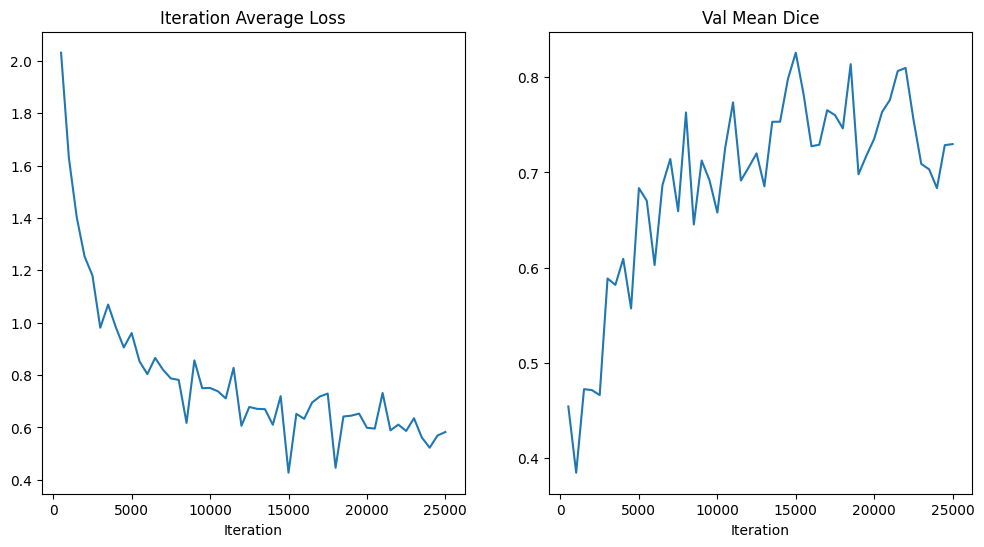

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.16it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.77471): 100%|█| 24/24 [00:14<00:00,  1.65it/
Training (47 / 25000 Steps) (loss=2.68342): 100%|█| 24/24 [00:12<00:00,  1.94it/
Training (71 / 25000 Steps) (loss=2.56440): 100%|█| 24/24 [00:12<00:00,  2.00it/
Training (95 / 25000 Steps) (loss=2.59894): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (119 / 25000 Steps) (loss=2.52135): 100%|█| 24/24 [00:12<00:00,  2.00it
Training (143 / 25000 Steps) (loss=2.47485): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (167 / 25000 Steps) (loss=2.49255): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (191 / 25000 Steps) (loss=2.35272): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (215 / 25000 Steps) (loss=2.36320): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (239 / 25000 Steps) (loss=2.28219): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (263 / 25000 Steps) (loss=2.10772): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (287 / 25000 Steps) (loss=2.20400): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.4418830871582031


Training (503 / 25000 Steps) (loss=1.90547): 100%|█| 24/24 [00:18<00:00,  1.31it
Training (527 / 25000 Steps) (loss=1.88335): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (551 / 25000 Steps) (loss=1.81717): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (575 / 25000 Steps) (loss=1.91130): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (599 / 25000 Steps) (loss=1.81339): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (623 / 25000 Steps) (loss=1.77338): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (647 / 25000 Steps) (loss=2.13764): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (671 / 25000 Steps) (loss=1.74398): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (695 / 25000 Steps) (loss=1.70900): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (719 / 25000 Steps) (loss=1.79389): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (743 / 25000 Steps) (loss=1.53307): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (767 / 25000 Steps) (loss=1.54374): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.4030543267726898


Training (1007 / 25000 Steps) (loss=1.80638): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (1031 / 25000 Steps) (loss=1.48064): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.39205): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=1.31410): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1103 / 25000 Steps) (loss=1.44909): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1127 / 25000 Steps) (loss=1.41886): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1151 / 25000 Steps) (loss=1.32162): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1175 / 25000 Steps) (loss=1.32279): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1199 / 25000 Steps) (loss=1.32368): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1223 / 25000 Steps) (loss=1.39955): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1247 / 25000 Steps) (loss=1.35575): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1271 / 25000 Steps) (loss=1.28927): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.4312881529331207


Training (1511 / 25000 Steps) (loss=1.22320): 100%|█| 24/24 [00:13<00:00,  1.73i
Training (1535 / 25000 Steps) (loss=1.28359): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1559 / 25000 Steps) (loss=1.25315): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1583 / 25000 Steps) (loss=1.26284): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1607 / 25000 Steps) (loss=1.24751): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1631 / 25000 Steps) (loss=1.20744): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1655 / 25000 Steps) (loss=1.27790): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1679 / 25000 Steps) (loss=1.16331): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1703 / 25000 Steps) (loss=1.16830): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1727 / 25000 Steps) (loss=1.30711): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1751 / 25000 Steps) (loss=1.20874): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1775 / 25000 Steps) (loss=1.30703): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.37445566058158875


Training (2015 / 25000 Steps) (loss=1.42013): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (2039 / 25000 Steps) (loss=1.14843): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2063 / 25000 Steps) (loss=1.29038): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2087 / 25000 Steps) (loss=1.05323): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2111 / 25000 Steps) (loss=1.10751): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2135 / 25000 Steps) (loss=1.09768): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2159 / 25000 Steps) (loss=1.07511): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2183 / 25000 Steps) (loss=1.24988): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2207 / 25000 Steps) (loss=1.32417): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2231 / 25000 Steps) (loss=1.14290): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2255 / 25000 Steps) (loss=1.21436): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2279 / 25000 Steps) (loss=1.02914): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.38437917828559875


Training (2519 / 25000 Steps) (loss=1.12494): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (2543 / 25000 Steps) (loss=1.04067): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2567 / 25000 Steps) (loss=1.22056): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2591 / 25000 Steps) (loss=0.97915): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2615 / 25000 Steps) (loss=1.23798): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2639 / 25000 Steps) (loss=1.04027): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2663 / 25000 Steps) (loss=1.13209): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2687 / 25000 Steps) (loss=1.05624): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2711 / 25000 Steps) (loss=1.05227): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2735 / 25000 Steps) (loss=1.24030): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2759 / 25000 Steps) (loss=1.11886): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2783 / 25000 Steps) (loss=0.97308): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4418830871582031 Current Avg. Dice: 0.4337520897388458


Training (3023 / 25000 Steps) (loss=0.99492): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (3047 / 25000 Steps) (loss=1.13427): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3071 / 25000 Steps) (loss=0.95657): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3095 / 25000 Steps) (loss=1.01041): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3119 / 25000 Steps) (loss=1.27896): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3143 / 25000 Steps) (loss=1.08644): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3167 / 25000 Steps) (loss=1.01822): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3191 / 25000 Steps) (loss=1.04684): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3215 / 25000 Steps) (loss=0.99602): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3239 / 25000 Steps) (loss=0.98026): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3263 / 25000 Steps) (loss=1.01511): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3287 / 25000 Steps) (loss=1.02796): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4480862617492676 Current Avg. Dice: 0.4480862617492676


Training (3503 / 25000 Steps) (loss=0.90246): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (3527 / 25000 Steps) (loss=0.92893): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3551 / 25000 Steps) (loss=0.93215): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3575 / 25000 Steps) (loss=0.99212): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3599 / 25000 Steps) (loss=0.93901): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3623 / 25000 Steps) (loss=1.08555): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3647 / 25000 Steps) (loss=0.92310): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3671 / 25000 Steps) (loss=0.95194): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3695 / 25000 Steps) (loss=0.98097): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3719 / 25000 Steps) (loss=0.94124): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3743 / 25000 Steps) (loss=0.93249): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=1.04749): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5309348106384277 Current Avg. Dice: 0.5309348106384277


Training (4007 / 25000 Steps) (loss=0.95655): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (4031 / 25000 Steps) (loss=0.88980): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4055 / 25000 Steps) (loss=0.92640): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4079 / 25000 Steps) (loss=0.95647): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4103 / 25000 Steps) (loss=0.90671): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4127 / 25000 Steps) (loss=0.87267): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=0.98709): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4175 / 25000 Steps) (loss=1.00780): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4199 / 25000 Steps) (loss=0.85187): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4223 / 25000 Steps) (loss=0.91621): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4247 / 25000 Steps) (loss=0.95286): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4271 / 25000 Steps) (loss=0.94713): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5309348106384277 Current Avg. Dice: 0.47348281741142273


Training (4511 / 25000 Steps) (loss=1.02799): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (4535 / 25000 Steps) (loss=0.83327): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=0.92778): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4583 / 25000 Steps) (loss=0.99480): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4607 / 25000 Steps) (loss=1.05966): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4631 / 25000 Steps) (loss=0.84416): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=1.00212): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4679 / 25000 Steps) (loss=0.99601): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4703 / 25000 Steps) (loss=0.87286): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4727 / 25000 Steps) (loss=0.99165): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4751 / 25000 Steps) (loss=1.06295): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4775 / 25000 Steps) (loss=0.79696): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5868776440620422 Current Avg. Dice: 0.5868776440620422


Training (5015 / 25000 Steps) (loss=0.87482): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (5039 / 25000 Steps) (loss=0.93441): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5063 / 25000 Steps) (loss=0.88914): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5087 / 25000 Steps) (loss=0.91768): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5111 / 25000 Steps) (loss=0.95977): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5135 / 25000 Steps) (loss=0.89826): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.72451): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5183 / 25000 Steps) (loss=0.91445): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5207 / 25000 Steps) (loss=0.86126): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5231 / 25000 Steps) (loss=0.93191): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5255 / 25000 Steps) (loss=0.92131): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5279 / 25000 Steps) (loss=0.88192): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5868776440620422 Current Avg. Dice: 0.5012948513031006


Training (5519 / 25000 Steps) (loss=0.95753): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5543 / 25000 Steps) (loss=0.84585): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5567 / 25000 Steps) (loss=0.95508): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5591 / 25000 Steps) (loss=0.73508): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5615 / 25000 Steps) (loss=0.83086): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5639 / 25000 Steps) (loss=0.88209): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5663 / 25000 Steps) (loss=0.82755): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5687 / 25000 Steps) (loss=0.82667): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5711 / 25000 Steps) (loss=0.99002): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=0.81344): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5759 / 25000 Steps) (loss=0.88677): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5783 / 25000 Steps) (loss=0.80840): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5868776440620422 Current Avg. Dice: 0.5277099609375


Training (6023 / 25000 Steps) (loss=0.73644): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (6047 / 25000 Steps) (loss=0.76680): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6071 / 25000 Steps) (loss=0.83957): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6095 / 25000 Steps) (loss=0.95007): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6119 / 25000 Steps) (loss=0.83691): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=0.82581): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6167 / 25000 Steps) (loss=0.78989): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6191 / 25000 Steps) (loss=0.74621): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6215 / 25000 Steps) (loss=0.80778): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6239 / 25000 Steps) (loss=0.92488): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6263 / 25000 Steps) (loss=0.85746): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6287 / 25000 Steps) (loss=0.84633): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6244028210639954 Current Avg. Dice: 0.6244028210639954


Training (6503 / 25000 Steps) (loss=0.78294): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6527 / 25000 Steps) (loss=0.76704): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6551 / 25000 Steps) (loss=0.78311): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6575 / 25000 Steps) (loss=0.73773): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.69971): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6623 / 25000 Steps) (loss=0.76546): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=0.75850): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6671 / 25000 Steps) (loss=0.74828): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6695 / 25000 Steps) (loss=0.83387): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6719 / 25000 Steps) (loss=0.99998): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6743 / 25000 Steps) (loss=0.84434): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.72381): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6244028210639954 Current Avg. Dice: 0.5480391979217529


Training (7007 / 25000 Steps) (loss=0.79130): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7031 / 25000 Steps) (loss=0.80948): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7055 / 25000 Steps) (loss=0.82336): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7079 / 25000 Steps) (loss=0.78699): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7103 / 25000 Steps) (loss=1.12068): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7127 / 25000 Steps) (loss=0.87161): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7151 / 25000 Steps) (loss=0.79670): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7175 / 25000 Steps) (loss=0.81645): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7199 / 25000 Steps) (loss=0.85848): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7223 / 25000 Steps) (loss=0.78530): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7247 / 25000 Steps) (loss=0.65124): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7271 / 25000 Steps) (loss=0.73000): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6392663717269897 Current Avg. Dice: 0.6392663717269897


Training (7511 / 25000 Steps) (loss=0.82151): 100%|█| 24/24 [00:19<00:00,  1.21i
Training (7535 / 25000 Steps) (loss=0.79983): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7559 / 25000 Steps) (loss=0.70504): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7583 / 25000 Steps) (loss=0.81060): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7607 / 25000 Steps) (loss=0.99251): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7631 / 25000 Steps) (loss=0.78956): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7655 / 25000 Steps) (loss=0.88588): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7679 / 25000 Steps) (loss=0.67479): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7703 / 25000 Steps) (loss=0.89237): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7727 / 25000 Steps) (loss=0.86259): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7751 / 25000 Steps) (loss=0.76166): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7775 / 25000 Steps) (loss=0.74641): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6679548621177673 Current Avg. Dice: 0.6679548621177673


Training (8015 / 25000 Steps) (loss=0.75990): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (8039 / 25000 Steps) (loss=0.78465): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8063 / 25000 Steps) (loss=0.75118): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8087 / 25000 Steps) (loss=0.79688): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8111 / 25000 Steps) (loss=0.79008): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8135 / 25000 Steps) (loss=0.67627): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8159 / 25000 Steps) (loss=0.73830): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=0.80353): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.86020): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8231 / 25000 Steps) (loss=0.80096): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8255 / 25000 Steps) (loss=0.75636): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8279 / 25000 Steps) (loss=0.85280): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6679548621177673 Current Avg. Dice: 0.5640711188316345


Training (8519 / 25000 Steps) (loss=0.66540): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (8543 / 25000 Steps) (loss=0.83644): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8567 / 25000 Steps) (loss=0.70115): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8591 / 25000 Steps) (loss=0.74401): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8615 / 25000 Steps) (loss=0.61715): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8639 / 25000 Steps) (loss=0.68696): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8663 / 25000 Steps) (loss=0.77954): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8687 / 25000 Steps) (loss=0.75994): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8711 / 25000 Steps) (loss=0.65513): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8735 / 25000 Steps) (loss=0.76855): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8759 / 25000 Steps) (loss=0.71683): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.55998): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6679548621177673 Current Avg. Dice: 0.6137937903404236


Training (9023 / 25000 Steps) (loss=0.89919): 100%|█| 24/24 [00:13<00:00,  1.81i
Training (9047 / 25000 Steps) (loss=0.77872): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9071 / 25000 Steps) (loss=0.61741): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9095 / 25000 Steps) (loss=0.71542): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9119 / 25000 Steps) (loss=0.77761): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.65357): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9167 / 25000 Steps) (loss=0.78147): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9191 / 25000 Steps) (loss=0.72661): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.59842): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9239 / 25000 Steps) (loss=0.76101): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9263 / 25000 Steps) (loss=0.70922): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9287 / 25000 Steps) (loss=0.83926): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6679548621177673 Current Avg. Dice: 0.6416738033294678


Training (9503 / 25000 Steps) (loss=0.78243): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (9527 / 25000 Steps) (loss=0.57631): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9551 / 25000 Steps) (loss=0.55731): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9575 / 25000 Steps) (loss=0.87737): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.79002): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9623 / 25000 Steps) (loss=0.58585): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9647 / 25000 Steps) (loss=0.69871): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9671 / 25000 Steps) (loss=0.75415): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9695 / 25000 Steps) (loss=0.76434): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9719 / 25000 Steps) (loss=0.70960): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9743 / 25000 Steps) (loss=0.57915): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9767 / 25000 Steps) (loss=0.69989): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6736753582954407 Current Avg. Dice: 0.6736753582954407


Training (10007 / 25000 Steps) (loss=0.77988): 100%|█| 24/24 [00:16<00:00,  1.42
Training (10031 / 25000 Steps) (loss=0.79207): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=0.71531): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10079 / 25000 Steps) (loss=0.68554): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10103 / 25000 Steps) (loss=0.69592): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=0.67818): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10151 / 25000 Steps) (loss=0.59934): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10175 / 25000 Steps) (loss=0.64188): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10199 / 25000 Steps) (loss=0.78138): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10223 / 25000 Steps) (loss=0.58971): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10247 / 25000 Steps) (loss=0.75665): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.82615): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6736753582954407 Current Avg. Dice: 0.588376522064209


Training (10511 / 25000 Steps) (loss=0.68659): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10535 / 25000 Steps) (loss=0.77899): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10559 / 25000 Steps) (loss=0.90641): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10583 / 25000 Steps) (loss=0.58003): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10607 / 25000 Steps) (loss=0.81135): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10631 / 25000 Steps) (loss=0.57439): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10655 / 25000 Steps) (loss=0.49621): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10679 / 25000 Steps) (loss=0.52087): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.63326): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10727 / 25000 Steps) (loss=0.69246): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.86604): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10775 / 25000 Steps) (loss=0.66808): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6736753582954407 Current Avg. Dice: 0.6563332080841064


Training (11015 / 25000 Steps) (loss=0.52057): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11039 / 25000 Steps) (loss=0.56747): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11063 / 25000 Steps) (loss=0.74824): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11087 / 25000 Steps) (loss=0.67607): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11111 / 25000 Steps) (loss=0.74361): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11135 / 25000 Steps) (loss=0.76272): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11159 / 25000 Steps) (loss=0.72403): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.53075): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11207 / 25000 Steps) (loss=0.66592): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11231 / 25000 Steps) (loss=0.91003): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11255 / 25000 Steps) (loss=0.76108): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11279 / 25000 Steps) (loss=0.57605): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6942338943481445 Current Avg. Dice: 0.6942338943481445


Training (11519 / 25000 Steps) (loss=0.52826): 100%|█| 24/24 [00:16<00:00,  1.42
Training (11543 / 25000 Steps) (loss=0.65423): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11567 / 25000 Steps) (loss=0.73595): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11591 / 25000 Steps) (loss=0.62275): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11615 / 25000 Steps) (loss=0.61815): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11639 / 25000 Steps) (loss=0.65077): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11663 / 25000 Steps) (loss=0.69588): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11687 / 25000 Steps) (loss=0.56903): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11711 / 25000 Steps) (loss=0.69623): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11735 / 25000 Steps) (loss=0.64534): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11759 / 25000 Steps) (loss=0.62243): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11783 / 25000 Steps) (loss=0.66402): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.7347885966300964


Training (12023 / 25000 Steps) (loss=0.69667): 100%|█| 24/24 [00:16<00:00,  1.42
Training (12047 / 25000 Steps) (loss=0.65392): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12071 / 25000 Steps) (loss=0.53540): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12095 / 25000 Steps) (loss=0.67679): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12119 / 25000 Steps) (loss=0.69410): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12143 / 25000 Steps) (loss=0.67786): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12167 / 25000 Steps) (loss=0.72038): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12191 / 25000 Steps) (loss=0.61543): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12215 / 25000 Steps) (loss=0.77545): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12239 / 25000 Steps) (loss=0.53394): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12263 / 25000 Steps) (loss=0.84645): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12287 / 25000 Steps) (loss=0.65620): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6870340704917908


Training (12503 / 25000 Steps) (loss=0.60736): 100%|█| 24/24 [00:13<00:00,  1.80
Training (12527 / 25000 Steps) (loss=0.61036): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12551 / 25000 Steps) (loss=0.67107): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.66311): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12599 / 25000 Steps) (loss=0.74627): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12623 / 25000 Steps) (loss=0.72141): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12647 / 25000 Steps) (loss=0.80504): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12671 / 25000 Steps) (loss=0.71844): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12695 / 25000 Steps) (loss=0.47863): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12719 / 25000 Steps) (loss=0.64864): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12743 / 25000 Steps) (loss=0.73860): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12767 / 25000 Steps) (loss=0.58459): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.5945639610290527


Training (13007 / 25000 Steps) (loss=0.76357): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13031 / 25000 Steps) (loss=0.61585): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13055 / 25000 Steps) (loss=0.51745): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13079 / 25000 Steps) (loss=0.51971): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13103 / 25000 Steps) (loss=0.59776): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13127 / 25000 Steps) (loss=0.47254): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13151 / 25000 Steps) (loss=0.69943): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13175 / 25000 Steps) (loss=0.70027): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13199 / 25000 Steps) (loss=0.69054): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13223 / 25000 Steps) (loss=0.68695): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13247 / 25000 Steps) (loss=0.71906): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13271 / 25000 Steps) (loss=0.40622): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6877828240394592


Training (13511 / 25000 Steps) (loss=0.52424): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13535 / 25000 Steps) (loss=0.63827): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13559 / 25000 Steps) (loss=0.77287): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13583 / 25000 Steps) (loss=0.56718): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13607 / 25000 Steps) (loss=0.61210): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13631 / 25000 Steps) (loss=0.86610): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13655 / 25000 Steps) (loss=0.70409): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13679 / 25000 Steps) (loss=0.56669): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13703 / 25000 Steps) (loss=0.60643): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13727 / 25000 Steps) (loss=0.81119): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13751 / 25000 Steps) (loss=0.71657): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13775 / 25000 Steps) (loss=0.78228): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6759945750236511


Training (14015 / 25000 Steps) (loss=0.61823): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14039 / 25000 Steps) (loss=0.67015): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14063 / 25000 Steps) (loss=0.66069): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14087 / 25000 Steps) (loss=0.61777): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14111 / 25000 Steps) (loss=0.71320): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14135 / 25000 Steps) (loss=0.61637): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14159 / 25000 Steps) (loss=0.49585): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14183 / 25000 Steps) (loss=0.60644): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14207 / 25000 Steps) (loss=0.91084): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14231 / 25000 Steps) (loss=0.65918): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14255 / 25000 Steps) (loss=0.69908): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.63087): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6674013137817383


Training (14519 / 25000 Steps) (loss=0.64675): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14543 / 25000 Steps) (loss=0.75271): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14567 / 25000 Steps) (loss=0.63390): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14591 / 25000 Steps) (loss=0.79503): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14615 / 25000 Steps) (loss=0.67414): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14639 / 25000 Steps) (loss=0.63348): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14663 / 25000 Steps) (loss=0.81526): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14687 / 25000 Steps) (loss=0.68191): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14711 / 25000 Steps) (loss=0.58617): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14735 / 25000 Steps) (loss=0.45697): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14759 / 25000 Steps) (loss=0.61894): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14783 / 25000 Steps) (loss=0.61183): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6459091305732727


Training (15023 / 25000 Steps) (loss=0.50330): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15047 / 25000 Steps) (loss=0.58467): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15071 / 25000 Steps) (loss=0.62378): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15095 / 25000 Steps) (loss=0.60266): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15119 / 25000 Steps) (loss=0.59270): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15143 / 25000 Steps) (loss=0.71692): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15167 / 25000 Steps) (loss=0.63915): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15191 / 25000 Steps) (loss=0.73024): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15215 / 25000 Steps) (loss=0.59028): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15239 / 25000 Steps) (loss=0.82820): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15263 / 25000 Steps) (loss=0.66271): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15287 / 25000 Steps) (loss=0.61902): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6990770697593689


Training (15503 / 25000 Steps) (loss=0.63009): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15527 / 25000 Steps) (loss=0.60510): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15551 / 25000 Steps) (loss=0.83212): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15575 / 25000 Steps) (loss=0.92314): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15599 / 25000 Steps) (loss=0.59337): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15623 / 25000 Steps) (loss=0.57979): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15647 / 25000 Steps) (loss=0.52975): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15671 / 25000 Steps) (loss=0.75928): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15695 / 25000 Steps) (loss=0.62939): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15719 / 25000 Steps) (loss=0.72724): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15743 / 25000 Steps) (loss=0.39930): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.55447): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.5848318934440613


Training (16007 / 25000 Steps) (loss=0.68446): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16031 / 25000 Steps) (loss=0.61384): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16055 / 25000 Steps) (loss=0.60569): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16079 / 25000 Steps) (loss=0.51391): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16103 / 25000 Steps) (loss=0.63170): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16127 / 25000 Steps) (loss=0.85024): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16151 / 25000 Steps) (loss=0.64439): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16175 / 25000 Steps) (loss=0.43943): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16199 / 25000 Steps) (loss=0.59377): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16223 / 25000 Steps) (loss=0.64156): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.43941): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16271 / 25000 Steps) (loss=0.82711): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.650663435459137


Training (16511 / 25000 Steps) (loss=0.62899): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16535 / 25000 Steps) (loss=0.68946): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16559 / 25000 Steps) (loss=0.66748): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16583 / 25000 Steps) (loss=0.37572): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.63224): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16631 / 25000 Steps) (loss=0.55809): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16655 / 25000 Steps) (loss=0.57650): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16679 / 25000 Steps) (loss=0.73049): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16703 / 25000 Steps) (loss=0.64395): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16727 / 25000 Steps) (loss=0.61097): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16751 / 25000 Steps) (loss=0.55177): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.63369): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.640731155872345


Training (17015 / 25000 Steps) (loss=0.76131): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17039 / 25000 Steps) (loss=0.52078): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17063 / 25000 Steps) (loss=0.70687): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17087 / 25000 Steps) (loss=0.50518): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17111 / 25000 Steps) (loss=0.59117): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17135 / 25000 Steps) (loss=0.63744): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.77841): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17183 / 25000 Steps) (loss=0.66511): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17207 / 25000 Steps) (loss=0.52596): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17231 / 25000 Steps) (loss=0.67489): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17255 / 25000 Steps) (loss=0.56918): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.53432): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.660572350025177


Training (17519 / 25000 Steps) (loss=0.70179): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.65985): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17567 / 25000 Steps) (loss=0.54162): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17591 / 25000 Steps) (loss=0.57950): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17615 / 25000 Steps) (loss=0.81530): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17639 / 25000 Steps) (loss=0.68179): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17663 / 25000 Steps) (loss=0.71994): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17687 / 25000 Steps) (loss=0.72614): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17711 / 25000 Steps) (loss=0.80198): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17735 / 25000 Steps) (loss=0.75482): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17759 / 25000 Steps) (loss=0.74800): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17783 / 25000 Steps) (loss=0.55606): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6951231360435486


Training (18023 / 25000 Steps) (loss=0.51826): 100%|█| 24/24 [00:13<00:00,  1.80
Training (18047 / 25000 Steps) (loss=0.48464): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18071 / 25000 Steps) (loss=0.45019): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18095 / 25000 Steps) (loss=0.51070): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18119 / 25000 Steps) (loss=0.62587): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18143 / 25000 Steps) (loss=0.63432): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.60267): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18191 / 25000 Steps) (loss=0.57326): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18215 / 25000 Steps) (loss=0.43842): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18239 / 25000 Steps) (loss=0.63444): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18263 / 25000 Steps) (loss=0.46977): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18287 / 25000 Steps) (loss=0.79458): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6417436599731445


Training (18503 / 25000 Steps) (loss=0.70399): 100%|█| 24/24 [00:13<00:00,  1.79
Training (18527 / 25000 Steps) (loss=0.67593): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18551 / 25000 Steps) (loss=0.60238): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18575 / 25000 Steps) (loss=0.75529): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18599 / 25000 Steps) (loss=0.45420): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18623 / 25000 Steps) (loss=0.78431): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18647 / 25000 Steps) (loss=0.64713): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18671 / 25000 Steps) (loss=0.58677): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18695 / 25000 Steps) (loss=0.56738): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18719 / 25000 Steps) (loss=0.61385): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18743 / 25000 Steps) (loss=0.41618): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18767 / 25000 Steps) (loss=0.66377): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6407302021980286


Training (19007 / 25000 Steps) (loss=0.56365): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19031 / 25000 Steps) (loss=0.72587): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19055 / 25000 Steps) (loss=0.48300): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19079 / 25000 Steps) (loss=0.56983): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19103 / 25000 Steps) (loss=0.62648): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19127 / 25000 Steps) (loss=0.59339): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.54318): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19175 / 25000 Steps) (loss=0.66884): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19199 / 25000 Steps) (loss=0.54767): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19223 / 25000 Steps) (loss=0.69800): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19247 / 25000 Steps) (loss=0.63648): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19271 / 25000 Steps) (loss=0.64491): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.7249543070793152


Training (19511 / 25000 Steps) (loss=0.48291): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19535 / 25000 Steps) (loss=0.41766): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19559 / 25000 Steps) (loss=0.57831): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19583 / 25000 Steps) (loss=0.56766): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19607 / 25000 Steps) (loss=0.75648): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.50968): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19655 / 25000 Steps) (loss=0.73846): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19679 / 25000 Steps) (loss=0.49035): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19703 / 25000 Steps) (loss=0.52470): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19727 / 25000 Steps) (loss=0.78545): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19751 / 25000 Steps) (loss=0.59364): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19775 / 25000 Steps) (loss=0.65216): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6426442265510559


Training (20015 / 25000 Steps) (loss=0.48096): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20039 / 25000 Steps) (loss=0.65164): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20063 / 25000 Steps) (loss=0.80570): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20087 / 25000 Steps) (loss=0.55578): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20111 / 25000 Steps) (loss=0.61573): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20135 / 25000 Steps) (loss=0.42699): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20159 / 25000 Steps) (loss=0.72708): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20183 / 25000 Steps) (loss=0.41249): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20207 / 25000 Steps) (loss=0.61616): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20231 / 25000 Steps) (loss=0.66268): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20255 / 25000 Steps) (loss=0.71864): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.61460): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6874809265136719


Training (20519 / 25000 Steps) (loss=0.43000): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20543 / 25000 Steps) (loss=0.73214): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20567 / 25000 Steps) (loss=0.74286): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20591 / 25000 Steps) (loss=0.71850): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20615 / 25000 Steps) (loss=0.59414): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20639 / 25000 Steps) (loss=0.48714): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.67083): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20687 / 25000 Steps) (loss=0.72364): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20711 / 25000 Steps) (loss=0.63115): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.52891): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20759 / 25000 Steps) (loss=0.51147): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20783 / 25000 Steps) (loss=0.79632): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7347885966300964 Current Avg. Dice: 0.6893946528434753


Training (21023 / 25000 Steps) (loss=0.52558): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21047 / 25000 Steps) (loss=0.44078): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21071 / 25000 Steps) (loss=0.46255): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21095 / 25000 Steps) (loss=0.48195): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21119 / 25000 Steps) (loss=0.53110): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.47476): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.55556): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21191 / 25000 Steps) (loss=0.78991): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21215 / 25000 Steps) (loss=0.55615): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21239 / 25000 Steps) (loss=0.65285): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21263 / 25000 Steps) (loss=0.70209): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21287 / 25000 Steps) (loss=0.74323): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.764708936214447


Training (21503 / 25000 Steps) (loss=0.70616): 100%|█| 24/24 [00:16<00:00,  1.42
Training (21527 / 25000 Steps) (loss=0.61787): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21551 / 25000 Steps) (loss=0.88900): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21575 / 25000 Steps) (loss=0.54153): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21599 / 25000 Steps) (loss=0.70556): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21623 / 25000 Steps) (loss=0.59671): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21647 / 25000 Steps) (loss=0.49682): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21671 / 25000 Steps) (loss=0.65852): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.73920): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21719 / 25000 Steps) (loss=0.61044): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21743 / 25000 Steps) (loss=0.55193): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21767 / 25000 Steps) (loss=0.44874): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.6827471256256104


Training (22007 / 25000 Steps) (loss=0.54871): 100%|█| 24/24 [00:13<00:00,  1.79
Training (22031 / 25000 Steps) (loss=0.64819): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22055 / 25000 Steps) (loss=0.38215): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22079 / 25000 Steps) (loss=0.54703): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22103 / 25000 Steps) (loss=0.56586): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22127 / 25000 Steps) (loss=0.66810): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22151 / 25000 Steps) (loss=0.63782): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22175 / 25000 Steps) (loss=0.75528): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.87546): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22223 / 25000 Steps) (loss=0.55908): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22247 / 25000 Steps) (loss=0.69955): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.65845): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.6769620776176453


Training (22511 / 25000 Steps) (loss=0.55440): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22535 / 25000 Steps) (loss=0.70845): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22559 / 25000 Steps) (loss=0.70915): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22583 / 25000 Steps) (loss=0.71099): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22607 / 25000 Steps) (loss=0.70048): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22631 / 25000 Steps) (loss=0.59959): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22655 / 25000 Steps) (loss=0.66084): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22679 / 25000 Steps) (loss=0.67193): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22703 / 25000 Steps) (loss=0.60517): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22727 / 25000 Steps) (loss=0.58081): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22751 / 25000 Steps) (loss=0.51069): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22775 / 25000 Steps) (loss=0.66873): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.7450416088104248


Training (23015 / 25000 Steps) (loss=0.66717): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23039 / 25000 Steps) (loss=0.53178): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23063 / 25000 Steps) (loss=0.79736): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23087 / 25000 Steps) (loss=0.71352): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23111 / 25000 Steps) (loss=0.63491): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23135 / 25000 Steps) (loss=0.45548): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23159 / 25000 Steps) (loss=0.56066): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23183 / 25000 Steps) (loss=0.48470): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23207 / 25000 Steps) (loss=0.43477): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23231 / 25000 Steps) (loss=0.78272): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23255 / 25000 Steps) (loss=0.59586): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23279 / 25000 Steps) (loss=0.42796): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.6748173832893372


Training (23519 / 25000 Steps) (loss=0.44241): 100%|█| 24/24 [00:13<00:00,  1.80
Training (23543 / 25000 Steps) (loss=0.70853): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23567 / 25000 Steps) (loss=0.56031): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23591 / 25000 Steps) (loss=0.75615): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23615 / 25000 Steps) (loss=0.46332): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23639 / 25000 Steps) (loss=0.62539): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23663 / 25000 Steps) (loss=0.64444): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23687 / 25000 Steps) (loss=0.57988): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23711 / 25000 Steps) (loss=0.72098): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23735 / 25000 Steps) (loss=0.70584): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23759 / 25000 Steps) (loss=0.51246): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23783 / 25000 Steps) (loss=0.65495): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.7278448939323425


Training (24023 / 25000 Steps) (loss=0.36205): 100%|█| 24/24 [00:13<00:00,  1.79
Training (24047 / 25000 Steps) (loss=0.60969): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24071 / 25000 Steps) (loss=0.57329): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24095 / 25000 Steps) (loss=0.60894): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24119 / 25000 Steps) (loss=0.55812): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24143 / 25000 Steps) (loss=0.57721): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.44189): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24191 / 25000 Steps) (loss=0.62434): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24215 / 25000 Steps) (loss=0.47109): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24239 / 25000 Steps) (loss=0.61019): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24263 / 25000 Steps) (loss=0.75054): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24287 / 25000 Steps) (loss=0.43827): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.7368887066841125


Training (24503 / 25000 Steps) (loss=0.58445): 100%|█| 24/24 [00:13<00:00,  1.80
Training (24527 / 25000 Steps) (loss=0.65030): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.58316): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.42483): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.76460): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.54782): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.38732): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24671 / 25000 Steps) (loss=0.74075): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24695 / 25000 Steps) (loss=0.76782): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24719 / 25000 Steps) (loss=0.67915): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.47238): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24767 / 25000 Steps) (loss=0.51255): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.764708936214447 Current Avg. Dice: 0.657356858253479


Training (25007 / 25000 Steps) (loss=0.74907): 100%|█| 24/24 [00:13<00:00,  1.79


RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "proj.weight", "proj.bias", "blocks.0.mlp.linear1.weight", "blocks.0.mlp.linear1.bias", "blocks.0.mlp.linear2.weight", "blocks.0.mlp.linear2.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.out_proj.weight", "blocks.0.attn.out_proj.bias", "blocks.0.attn.qkv.weight", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.1.mlp.linear1.weight", "blocks.1.mlp.linear1.bias", "blocks.1.mlp.linear2.weight", "blocks.1.mlp.linear2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.out_proj.weight", "blocks.1.attn.out_proj.bias", "blocks.1.attn.qkv.weight", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.2.mlp.linear1.weight", "blocks.2.mlp.linear1.bias", "blocks.2.mlp.linear2.weight", "blocks.2.mlp.linear2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.out_proj.weight", "blocks.2.attn.out_proj.bias", "blocks.2.attn.qkv.weight", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.3.mlp.linear1.weight", "blocks.3.mlp.linear1.bias", "blocks.3.mlp.linear2.weight", "blocks.3.mlp.linear2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.out_proj.weight", "blocks.3.attn.out_proj.bias", "blocks.3.attn.qkv.weight", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.4.mlp.linear1.weight", "blocks.4.mlp.linear1.bias", "blocks.4.mlp.linear2.weight", "blocks.4.mlp.linear2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.out_proj.weight", "blocks.4.attn.out_proj.bias", "blocks.4.attn.qkv.weight", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.5.mlp.linear1.weight", "blocks.5.mlp.linear1.bias", "blocks.5.mlp.linear2.weight", "blocks.5.mlp.linear2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.out_proj.weight", "blocks.5.attn.out_proj.bias", "blocks.5.attn.qkv.weight", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.6.mlp.linear1.weight", "blocks.6.mlp.linear1.bias", "blocks.6.mlp.linear2.weight", "blocks.6.mlp.linear2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.out_proj.weight", "blocks.6.attn.out_proj.bias", "blocks.6.attn.qkv.weight", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.7.mlp.linear1.weight", "blocks.7.mlp.linear1.bias", "blocks.7.mlp.linear2.weight", "blocks.7.mlp.linear2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.out_proj.weight", "blocks.7.attn.out_proj.bias", "blocks.7.attn.qkv.weight", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.8.mlp.linear1.weight", "blocks.8.mlp.linear1.bias", "blocks.8.mlp.linear2.weight", "blocks.8.mlp.linear2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.out_proj.weight", "blocks.8.attn.out_proj.bias", "blocks.8.attn.qkv.weight", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.9.mlp.linear1.weight", "blocks.9.mlp.linear1.bias", "blocks.9.mlp.linear2.weight", "blocks.9.mlp.linear2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.out_proj.weight", "blocks.9.attn.out_proj.bias", "blocks.9.attn.qkv.weight", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.10.mlp.linear1.weight", "blocks.10.mlp.linear1.bias", "blocks.10.mlp.linear2.weight", "blocks.10.mlp.linear2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.out_proj.weight", "blocks.10.attn.out_proj.bias", "blocks.10.attn.qkv.weight", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.11.mlp.linear1.weight", "blocks.11.mlp.linear1.bias", "blocks.11.mlp.linear2.weight", "blocks.11.mlp.linear2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.out_proj.weight", "blocks.11.attn.out_proj.bias", "blocks.11.attn.qkv.weight", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "norm.weight", "norm.bias". 

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7647 at iteration: 21500


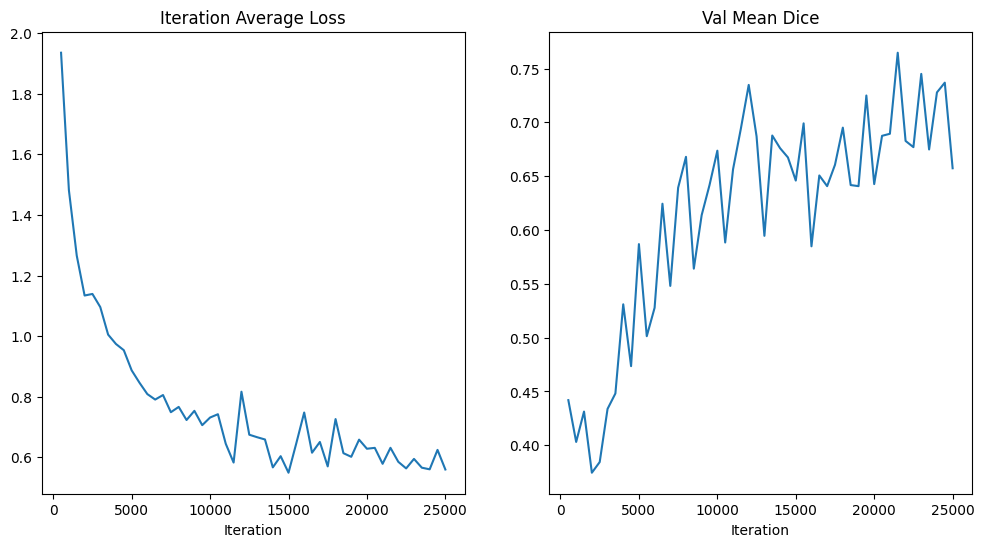

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "dwtunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         print(x.shape,y.shape)
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "wavevit_unetr_onlyconcat_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.27340): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.22891): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (71 / 25000 Steps) (loss=2.09495): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (95 / 25000 Steps) (loss=2.11504): 100%|█| 24/24 [00:11<00:00,  2.01it/
Training (119 / 25000 Steps) (loss=2.04187): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (143 / 25000 Steps) (loss=1.96396): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (167 / 25000 Steps) (loss=1.84766): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (191 / 25000 Steps) (loss=1.95995): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (215 / 25000 Steps) (loss=1.86468): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (239 / 25000 Steps) (loss=1.86758): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (263 / 25000 Steps) (loss=1.85714): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (287 / 25000 Steps) (loss=1.73119): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.42387834191322327


Training (503 / 25000 Steps) (loss=1.49979): 100%|█| 24/24 [00:16<00:00,  1.45it
Training (527 / 25000 Steps) (loss=1.57896): 100%|█| 24/24 [00:11<00:00,  2.02it
Training (551 / 25000 Steps) (loss=1.73657): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (575 / 25000 Steps) (loss=1.46458): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (599 / 25000 Steps) (loss=1.56739): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (623 / 25000 Steps) (loss=1.58719): 100%|█| 24/24 [00:11<00:00,  2.01it
Training (647 / 25000 Steps) (loss=1.54012): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (671 / 25000 Steps) (loss=1.40285): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (695 / 25000 Steps) (loss=1.36975): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (719 / 25000 Steps) (loss=1.33068): 100%|█| 24/24 [00:11<00:00,  2.00it
Training (743 / 25000 Steps) (loss=1.41774): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (767 / 25000 Steps) (loss=1.35549): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.31853583455085754


Training (1007 / 25000 Steps) (loss=1.36383): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (1031 / 25000 Steps) (loss=1.20332): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.17627): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1079 / 25000 Steps) (loss=1.18828): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1103 / 25000 Steps) (loss=1.38888): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1127 / 25000 Steps) (loss=1.26312): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1151 / 25000 Steps) (loss=1.20053): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1175 / 25000 Steps) (loss=1.52668): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1199 / 25000 Steps) (loss=1.25293): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1223 / 25000 Steps) (loss=1.22267): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1247 / 25000 Steps) (loss=1.08897): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1271 / 25000 Steps) (loss=1.05962): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.3721740245819092


Training (1511 / 25000 Steps) (loss=1.12034): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (1535 / 25000 Steps) (loss=1.22227): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1559 / 25000 Steps) (loss=1.17038): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1583 / 25000 Steps) (loss=1.05422): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1607 / 25000 Steps) (loss=1.32686): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1631 / 25000 Steps) (loss=1.06915): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=1.24763): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1679 / 25000 Steps) (loss=1.03320): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1703 / 25000 Steps) (loss=1.20450): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (1727 / 25000 Steps) (loss=1.27296): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1751 / 25000 Steps) (loss=1.07789): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1775 / 25000 Steps) (loss=1.11276): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.38570287823677063


Training (2015 / 25000 Steps) (loss=1.28761): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2039 / 25000 Steps) (loss=1.02105): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2063 / 25000 Steps) (loss=1.12222): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2087 / 25000 Steps) (loss=1.00177): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2111 / 25000 Steps) (loss=1.06837): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2135 / 25000 Steps) (loss=1.24214): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2159 / 25000 Steps) (loss=1.06462): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2183 / 25000 Steps) (loss=1.10256): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2207 / 25000 Steps) (loss=1.13862): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (2231 / 25000 Steps) (loss=1.02642): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2255 / 25000 Steps) (loss=1.23140): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2279 / 25000 Steps) (loss=1.09501): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.38670459389686584


Training (2519 / 25000 Steps) (loss=0.97203): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (2543 / 25000 Steps) (loss=1.00173): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2567 / 25000 Steps) (loss=1.06029): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2591 / 25000 Steps) (loss=1.04332): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2615 / 25000 Steps) (loss=1.50847): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2639 / 25000 Steps) (loss=1.14033): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2663 / 25000 Steps) (loss=1.30550): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2687 / 25000 Steps) (loss=0.97898): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2711 / 25000 Steps) (loss=1.04901): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2735 / 25000 Steps) (loss=1.10306): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2759 / 25000 Steps) (loss=1.25517): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2783 / 25000 Steps) (loss=1.15728): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.42387834191322327 Current Avg. Dice: 0.4132847487926483


Training (3023 / 25000 Steps) (loss=1.02111): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (3047 / 25000 Steps) (loss=1.20181): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3071 / 25000 Steps) (loss=1.02317): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3095 / 25000 Steps) (loss=1.00066): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3119 / 25000 Steps) (loss=1.10165): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3143 / 25000 Steps) (loss=0.96343): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3167 / 25000 Steps) (loss=1.98649): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3191 / 25000 Steps) (loss=1.25010): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3215 / 25000 Steps) (loss=1.12424): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3239 / 25000 Steps) (loss=1.05545): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3263 / 25000 Steps) (loss=0.99258): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3287 / 25000 Steps) (loss=0.93811): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4494531452655792 Current Avg. Dice: 0.4494531452655792


Training (3503 / 25000 Steps) (loss=0.88782): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (3527 / 25000 Steps) (loss=0.92275): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3551 / 25000 Steps) (loss=0.91901): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3575 / 25000 Steps) (loss=0.95695): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3599 / 25000 Steps) (loss=0.95808): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3623 / 25000 Steps) (loss=1.28426): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3647 / 25000 Steps) (loss=1.15255): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (3671 / 25000 Steps) (loss=0.91658): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3695 / 25000 Steps) (loss=1.03545): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3719 / 25000 Steps) (loss=1.30395): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3743 / 25000 Steps) (loss=1.04990): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (3767 / 25000 Steps) (loss=0.89313): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5310638546943665 Current Avg. Dice: 0.5310638546943665


Training (4007 / 25000 Steps) (loss=0.93354): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (4031 / 25000 Steps) (loss=1.05089): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4055 / 25000 Steps) (loss=1.11691): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4079 / 25000 Steps) (loss=1.01548): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4103 / 25000 Steps) (loss=0.98720): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4127 / 25000 Steps) (loss=0.92433): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4151 / 25000 Steps) (loss=1.05539): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4175 / 25000 Steps) (loss=0.92001): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4199 / 25000 Steps) (loss=0.93787): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4223 / 25000 Steps) (loss=0.90854): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4247 / 25000 Steps) (loss=0.92350): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4271 / 25000 Steps) (loss=1.07718): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5406673550605774 Current Avg. Dice: 0.5406673550605774


Training (4511 / 25000 Steps) (loss=1.03815): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (4535 / 25000 Steps) (loss=1.08922): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4559 / 25000 Steps) (loss=0.94529): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4583 / 25000 Steps) (loss=0.89515): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4607 / 25000 Steps) (loss=0.84360): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4631 / 25000 Steps) (loss=0.78449): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4655 / 25000 Steps) (loss=0.85541): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4679 / 25000 Steps) (loss=0.90274): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4703 / 25000 Steps) (loss=1.06996): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (4727 / 25000 Steps) (loss=0.90762): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4751 / 25000 Steps) (loss=0.89084): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4775 / 25000 Steps) (loss=0.85285): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5406673550605774 Current Avg. Dice: 0.49637314677238464


Training (5015 / 25000 Steps) (loss=0.92931): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (5039 / 25000 Steps) (loss=0.90596): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5063 / 25000 Steps) (loss=0.86345): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5087 / 25000 Steps) (loss=0.95225): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5111 / 25000 Steps) (loss=0.85186): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5135 / 25000 Steps) (loss=0.83340): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5159 / 25000 Steps) (loss=0.95834): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5183 / 25000 Steps) (loss=0.86290): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5207 / 25000 Steps) (loss=0.92381): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5231 / 25000 Steps) (loss=0.86904): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5255 / 25000 Steps) (loss=0.81229): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5279 / 25000 Steps) (loss=0.89544): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5564660429954529 Current Avg. Dice: 0.5564660429954529


Training (5519 / 25000 Steps) (loss=0.92213): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (5543 / 25000 Steps) (loss=0.88274): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5567 / 25000 Steps) (loss=0.85029): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5591 / 25000 Steps) (loss=0.98354): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5615 / 25000 Steps) (loss=0.78025): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5639 / 25000 Steps) (loss=0.80013): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5663 / 25000 Steps) (loss=0.92385): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5687 / 25000 Steps) (loss=0.96468): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5711 / 25000 Steps) (loss=1.00669): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5735 / 25000 Steps) (loss=1.08416): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5759 / 25000 Steps) (loss=0.82349): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (5783 / 25000 Steps) (loss=0.79403): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5880699157714844 Current Avg. Dice: 0.5880699157714844


Training (6023 / 25000 Steps) (loss=0.83304): 100%|█| 24/24 [00:16<00:00,  1.43i
Training (6047 / 25000 Steps) (loss=0.95453): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6071 / 25000 Steps) (loss=0.89870): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6095 / 25000 Steps) (loss=0.71494): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6119 / 25000 Steps) (loss=0.83881): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6143 / 25000 Steps) (loss=0.85925): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6167 / 25000 Steps) (loss=0.86149): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6191 / 25000 Steps) (loss=0.90604): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6215 / 25000 Steps) (loss=0.89919): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6239 / 25000 Steps) (loss=0.72981): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6263 / 25000 Steps) (loss=0.92441): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6287 / 25000 Steps) (loss=0.84145): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6321939826011658 Current Avg. Dice: 0.6321939826011658


Training (6503 / 25000 Steps) (loss=0.87028): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (6527 / 25000 Steps) (loss=0.89137): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6551 / 25000 Steps) (loss=0.90576): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (6575 / 25000 Steps) (loss=0.75368): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6599 / 25000 Steps) (loss=0.86066): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6623 / 25000 Steps) (loss=0.86027): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6647 / 25000 Steps) (loss=0.89608): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6671 / 25000 Steps) (loss=1.14707): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6695 / 25000 Steps) (loss=0.71039): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6719 / 25000 Steps) (loss=0.84533): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6743 / 25000 Steps) (loss=0.81936): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6767 / 25000 Steps) (loss=0.88419): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6321939826011658 Current Avg. Dice: 0.6002733111381531


Training (7007 / 25000 Steps) (loss=0.85287): 100%|█| 24/24 [00:13<00:00,  1.80i
Training (7031 / 25000 Steps) (loss=0.97486): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7055 / 25000 Steps) (loss=0.73721): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7079 / 25000 Steps) (loss=1.23187): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7103 / 25000 Steps) (loss=0.98018): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7127 / 25000 Steps) (loss=0.76384): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7151 / 25000 Steps) (loss=0.84887): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7175 / 25000 Steps) (loss=0.76352): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7199 / 25000 Steps) (loss=0.75365): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7223 / 25000 Steps) (loss=0.82173): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7247 / 25000 Steps) (loss=0.65834): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7271 / 25000 Steps) (loss=0.64316): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6321939826011658 Current Avg. Dice: 0.53411465883255


Training (7511 / 25000 Steps) (loss=0.89667): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (7535 / 25000 Steps) (loss=0.65351): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7559 / 25000 Steps) (loss=0.81043): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7583 / 25000 Steps) (loss=0.68127): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7607 / 25000 Steps) (loss=0.70793): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7631 / 25000 Steps) (loss=0.85268): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (7655 / 25000 Steps) (loss=0.82858): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7679 / 25000 Steps) (loss=0.68553): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7703 / 25000 Steps) (loss=0.80340): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7727 / 25000 Steps) (loss=0.72710): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7751 / 25000 Steps) (loss=0.84508): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7775 / 25000 Steps) (loss=1.14150): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6527889370918274 Current Avg. Dice: 0.6527889370918274


Training (8015 / 25000 Steps) (loss=0.76519): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (8039 / 25000 Steps) (loss=0.74378): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8063 / 25000 Steps) (loss=1.55265): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8087 / 25000 Steps) (loss=0.79908): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8111 / 25000 Steps) (loss=0.69277): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8135 / 25000 Steps) (loss=0.69665): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8159 / 25000 Steps) (loss=0.72600): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8183 / 25000 Steps) (loss=0.79095): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8207 / 25000 Steps) (loss=0.81125): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8231 / 25000 Steps) (loss=0.75299): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8255 / 25000 Steps) (loss=0.64446): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8279 / 25000 Steps) (loss=0.77802): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6527889370918274 Current Avg. Dice: 0.5865605473518372


Training (8519 / 25000 Steps) (loss=0.71347): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (8543 / 25000 Steps) (loss=1.10385): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8567 / 25000 Steps) (loss=0.82771): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8591 / 25000 Steps) (loss=0.64433): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8615 / 25000 Steps) (loss=0.69201): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8639 / 25000 Steps) (loss=1.08925): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8663 / 25000 Steps) (loss=0.64977): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8687 / 25000 Steps) (loss=0.77277): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8711 / 25000 Steps) (loss=0.75873): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (8735 / 25000 Steps) (loss=0.74117): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8759 / 25000 Steps) (loss=0.79686): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8783 / 25000 Steps) (loss=0.83556): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6696167588233948 Current Avg. Dice: 0.6696167588233948


Training (9023 / 25000 Steps) (loss=0.65009): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (9047 / 25000 Steps) (loss=0.69698): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9071 / 25000 Steps) (loss=0.97283): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9095 / 25000 Steps) (loss=0.74299): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9119 / 25000 Steps) (loss=0.76158): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9143 / 25000 Steps) (loss=0.67792): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9167 / 25000 Steps) (loss=0.66843): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9191 / 25000 Steps) (loss=0.67337): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9215 / 25000 Steps) (loss=0.79943): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9239 / 25000 Steps) (loss=1.16981): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9263 / 25000 Steps) (loss=0.47562): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9287 / 25000 Steps) (loss=0.83639): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7107953429222107 Current Avg. Dice: 0.7107953429222107


Training (9503 / 25000 Steps) (loss=0.81730): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (9527 / 25000 Steps) (loss=0.72529): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9551 / 25000 Steps) (loss=0.82691): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9575 / 25000 Steps) (loss=0.80090): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9599 / 25000 Steps) (loss=0.63962): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9623 / 25000 Steps) (loss=0.79926): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9647 / 25000 Steps) (loss=0.59072): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9671 / 25000 Steps) (loss=0.85411): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9695 / 25000 Steps) (loss=0.62693): 100%|█| 24/24 [00:11<00:00,  2.03i
Training (9719 / 25000 Steps) (loss=1.04982): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9743 / 25000 Steps) (loss=0.74041): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9767 / 25000 Steps) (loss=0.77984): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7107953429222107 Current Avg. Dice: 0.628781259059906


Training (10007 / 25000 Steps) (loss=0.53491): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10031 / 25000 Steps) (loss=0.74710): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10055 / 25000 Steps) (loss=0.60218): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10079 / 25000 Steps) (loss=0.69275): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10103 / 25000 Steps) (loss=0.78766): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10127 / 25000 Steps) (loss=0.72160): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10151 / 25000 Steps) (loss=0.75827): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10175 / 25000 Steps) (loss=0.76184): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10199 / 25000 Steps) (loss=0.85840): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10223 / 25000 Steps) (loss=0.73787): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10247 / 25000 Steps) (loss=0.69552): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10271 / 25000 Steps) (loss=0.71498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7107953429222107 Current Avg. Dice: 0.6769618391990662


Training (10511 / 25000 Steps) (loss=0.72265): 100%|█| 24/24 [00:13<00:00,  1.80
Training (10535 / 25000 Steps) (loss=0.68381): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10559 / 25000 Steps) (loss=0.67582): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10583 / 25000 Steps) (loss=0.60741): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10607 / 25000 Steps) (loss=0.70707): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10631 / 25000 Steps) (loss=0.54272): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10655 / 25000 Steps) (loss=0.76080): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10679 / 25000 Steps) (loss=0.73800): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10703 / 25000 Steps) (loss=0.67588): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10727 / 25000 Steps) (loss=0.45044): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10751 / 25000 Steps) (loss=0.83027): 100%|█| 24/24 [00:11<00:00,  2.03
Training (10775 / 25000 Steps) (loss=0.62063): 100%|█| 24/24 [00:11<00:00,  2.02
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7107953429222107 Current Avg. Dice: 0.6519710421562195


Training (11015 / 25000 Steps) (loss=1.10517): 100%|█| 24/24 [00:13<00:00,  1.80
Training (11039 / 25000 Steps) (loss=0.64595): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11063 / 25000 Steps) (loss=0.69039): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11087 / 25000 Steps) (loss=0.77484): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11111 / 25000 Steps) (loss=0.81769): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11135 / 25000 Steps) (loss=0.66738): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11159 / 25000 Steps) (loss=0.77633): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11183 / 25000 Steps) (loss=0.73291): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11207 / 25000 Steps) (loss=0.75989): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11231 / 25000 Steps) (loss=0.71165): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11255 / 25000 Steps) (loss=0.80833): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11279 / 25000 Steps) (loss=0.81539): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7107953429222107 Current Avg. Dice: 0.6839313507080078


Training (11519 / 25000 Steps) (loss=0.40318): 100%|█| 24/24 [00:13<00:00,  1.79
Training (11543 / 25000 Steps) (loss=0.54378): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11567 / 25000 Steps) (loss=0.73886): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11591 / 25000 Steps) (loss=0.75183): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11615 / 25000 Steps) (loss=0.69751): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11639 / 25000 Steps) (loss=0.71942): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11663 / 25000 Steps) (loss=0.65686): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11687 / 25000 Steps) (loss=0.65224): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11711 / 25000 Steps) (loss=0.61404): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11735 / 25000 Steps) (loss=0.72671): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11759 / 25000 Steps) (loss=0.77671): 100%|█| 24/24 [00:11<00:00,  2.03
Training (11783 / 25000 Steps) (loss=0.71397): 100%|█| 24/24 [00:11<00:00,  2.02
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7146978378295898 Current Avg. Dice: 0.7146978378295898


Training (12023 / 25000 Steps) (loss=0.60285): 100%|█| 24/24 [00:16<00:00,  1.41
Training (12047 / 25000 Steps) (loss=0.74248): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12071 / 25000 Steps) (loss=0.67053): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12095 / 25000 Steps) (loss=0.43462): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12119 / 25000 Steps) (loss=0.65971): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12143 / 25000 Steps) (loss=0.81109): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12167 / 25000 Steps) (loss=0.73172): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12191 / 25000 Steps) (loss=0.79199): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12215 / 25000 Steps) (loss=0.71805): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12239 / 25000 Steps) (loss=0.68280): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12263 / 25000 Steps) (loss=0.69871): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12287 / 25000 Steps) (loss=0.71293): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7146978378295898 Current Avg. Dice: 0.6823522448539734


Training (12503 / 25000 Steps) (loss=0.68500): 100%|█| 24/24 [00:13<00:00,  1.81
Training (12527 / 25000 Steps) (loss=0.82561): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12551 / 25000 Steps) (loss=0.69828): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12575 / 25000 Steps) (loss=0.80024): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12599 / 25000 Steps) (loss=0.52845): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12623 / 25000 Steps) (loss=0.82953): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12647 / 25000 Steps) (loss=0.68124): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12671 / 25000 Steps) (loss=0.62100): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12695 / 25000 Steps) (loss=0.72213): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12719 / 25000 Steps) (loss=0.70401): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12743 / 25000 Steps) (loss=0.61896): 100%|█| 24/24 [00:11<00:00,  2.02
Training (12767 / 25000 Steps) (loss=0.64175): 100%|█| 24/24 [00:11<00:00,  2.03
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7322972416877747 Current Avg. Dice: 0.7322972416877747


Training (13007 / 25000 Steps) (loss=0.73363): 100%|█| 24/24 [00:16<00:00,  1.43
Training (13031 / 25000 Steps) (loss=0.71133): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13055 / 25000 Steps) (loss=0.68362): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13079 / 25000 Steps) (loss=0.67162): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13103 / 25000 Steps) (loss=0.66011): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13127 / 25000 Steps) (loss=0.80052): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13151 / 25000 Steps) (loss=0.65223): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13175 / 25000 Steps) (loss=0.73325): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13199 / 25000 Steps) (loss=0.66895): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13223 / 25000 Steps) (loss=0.72630): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13247 / 25000 Steps) (loss=0.57496): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13271 / 25000 Steps) (loss=0.72685): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7322972416877747 Current Avg. Dice: 0.7008266448974609


Training (13511 / 25000 Steps) (loss=0.79367): 100%|█| 24/24 [00:13<00:00,  1.80
Training (13535 / 25000 Steps) (loss=0.58591): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13559 / 25000 Steps) (loss=0.66964): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13583 / 25000 Steps) (loss=0.55218): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13607 / 25000 Steps) (loss=0.74898): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13631 / 25000 Steps) (loss=0.61549): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13655 / 25000 Steps) (loss=0.70808): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13679 / 25000 Steps) (loss=0.76721): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13703 / 25000 Steps) (loss=0.52652): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13727 / 25000 Steps) (loss=0.65977): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13751 / 25000 Steps) (loss=0.63250): 100%|█| 24/24 [00:11<00:00,  2.02
Training (13775 / 25000 Steps) (loss=0.65711): 100%|█| 24/24 [00:11<00:00,  2.03
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7322972416877747 Current Avg. Dice: 0.7017002701759338


Training (14015 / 25000 Steps) (loss=0.68635): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14039 / 25000 Steps) (loss=0.78236): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14063 / 25000 Steps) (loss=0.60171): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14087 / 25000 Steps) (loss=0.65565): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14111 / 25000 Steps) (loss=0.71523): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14135 / 25000 Steps) (loss=0.49715): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14159 / 25000 Steps) (loss=0.76133): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14183 / 25000 Steps) (loss=0.42929): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14207 / 25000 Steps) (loss=0.48020): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14231 / 25000 Steps) (loss=0.79447): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14255 / 25000 Steps) (loss=0.63489): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14279 / 25000 Steps) (loss=0.70739): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7322972416877747 Current Avg. Dice: 0.7188796997070312


Training (14519 / 25000 Steps) (loss=0.72595): 100%|█| 24/24 [00:13<00:00,  1.80
Training (14543 / 25000 Steps) (loss=0.61707): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14567 / 25000 Steps) (loss=0.65129): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14591 / 25000 Steps) (loss=0.66975): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14615 / 25000 Steps) (loss=0.60236): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14639 / 25000 Steps) (loss=0.59299): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14663 / 25000 Steps) (loss=0.48834): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14687 / 25000 Steps) (loss=0.59092): 100%|█| 24/24 [00:11<00:00,  2.03
Training (14711 / 25000 Steps) (loss=0.50360): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14735 / 25000 Steps) (loss=0.79178): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14759 / 25000 Steps) (loss=0.54712): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14783 / 25000 Steps) (loss=0.54334): 100%|█| 24/24 [00:11<00:00,  2.02
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7322972416877747 Current Avg. Dice: 0.7119095921516418


Training (15023 / 25000 Steps) (loss=0.66471): 100%|█| 24/24 [00:13<00:00,  1.80
Training (15047 / 25000 Steps) (loss=0.67380): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15071 / 25000 Steps) (loss=0.68788): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15095 / 25000 Steps) (loss=0.67734): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15119 / 25000 Steps) (loss=0.47105): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15143 / 25000 Steps) (loss=0.53871): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15167 / 25000 Steps) (loss=0.48729): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15191 / 25000 Steps) (loss=0.72494): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15215 / 25000 Steps) (loss=0.71333): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15239 / 25000 Steps) (loss=0.79998): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15263 / 25000 Steps) (loss=0.65870): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15287 / 25000 Steps) (loss=0.51129): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7621392607688904 Current Avg. Dice: 0.7621392607688904


Training (15503 / 25000 Steps) (loss=0.66995): 100%|█| 24/24 [00:16<00:00,  1.42
Training (15527 / 25000 Steps) (loss=0.63244): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15551 / 25000 Steps) (loss=0.66050): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15575 / 25000 Steps) (loss=0.58476): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15599 / 25000 Steps) (loss=0.58498): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15623 / 25000 Steps) (loss=0.75077): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15647 / 25000 Steps) (loss=0.62377): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15671 / 25000 Steps) (loss=0.65234): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15695 / 25000 Steps) (loss=0.62271): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15719 / 25000 Steps) (loss=0.76049): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15743 / 25000 Steps) (loss=0.71879): 100%|█| 24/24 [00:11<00:00,  2.02
Training (15767 / 25000 Steps) (loss=0.63354): 100%|█| 24/24 [00:11<00:00,  2.03
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7621392607688904 Current Avg. Dice: 0.6483538150787354


Training (16007 / 25000 Steps) (loss=0.51440): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16031 / 25000 Steps) (loss=0.75571): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16055 / 25000 Steps) (loss=0.57978): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16079 / 25000 Steps) (loss=0.71010): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16103 / 25000 Steps) (loss=0.57405): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16127 / 25000 Steps) (loss=0.54733): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16151 / 25000 Steps) (loss=0.51972): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16175 / 25000 Steps) (loss=0.54561): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16199 / 25000 Steps) (loss=0.77515): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16223 / 25000 Steps) (loss=0.76693): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16247 / 25000 Steps) (loss=0.77072): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16271 / 25000 Steps) (loss=0.52860): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7621392607688904 Current Avg. Dice: 0.6904860138893127


Training (16511 / 25000 Steps) (loss=0.87766): 100%|█| 24/24 [00:13<00:00,  1.80
Training (16535 / 25000 Steps) (loss=0.78054): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16559 / 25000 Steps) (loss=0.77056): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16583 / 25000 Steps) (loss=0.74998): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16607 / 25000 Steps) (loss=0.99386): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16631 / 25000 Steps) (loss=0.67272): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16655 / 25000 Steps) (loss=0.58937): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16679 / 25000 Steps) (loss=0.48815): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16703 / 25000 Steps) (loss=0.78569): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16727 / 25000 Steps) (loss=0.54116): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16751 / 25000 Steps) (loss=0.69162): 100%|█| 24/24 [00:11<00:00,  2.02
Training (16775 / 25000 Steps) (loss=0.72228): 100%|█| 24/24 [00:11<00:00,  2.03
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7621392607688904 Current Avg. Dice: 0.7042930126190186


Training (17015 / 25000 Steps) (loss=0.52139): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17039 / 25000 Steps) (loss=0.62356): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17063 / 25000 Steps) (loss=0.57417): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17087 / 25000 Steps) (loss=0.70164): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17111 / 25000 Steps) (loss=0.47872): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17135 / 25000 Steps) (loss=0.77215): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17159 / 25000 Steps) (loss=0.85899): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17183 / 25000 Steps) (loss=0.70300): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17207 / 25000 Steps) (loss=0.64462): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17231 / 25000 Steps) (loss=0.73205): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17255 / 25000 Steps) (loss=0.70128): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17279 / 25000 Steps) (loss=0.79167): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7621392607688904 Current Avg. Dice: 0.6837630271911621


Training (17519 / 25000 Steps) (loss=0.47257): 100%|█| 24/24 [00:13<00:00,  1.80
Training (17543 / 25000 Steps) (loss=0.66721): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17567 / 25000 Steps) (loss=0.69736): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17591 / 25000 Steps) (loss=0.67389): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17615 / 25000 Steps) (loss=0.64589): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17639 / 25000 Steps) (loss=0.77532): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17663 / 25000 Steps) (loss=0.46285): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17687 / 25000 Steps) (loss=0.54353): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17711 / 25000 Steps) (loss=0.63381): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17735 / 25000 Steps) (loss=0.58723): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17759 / 25000 Steps) (loss=0.67803): 100%|█| 24/24 [00:11<00:00,  2.03
Training (17783 / 25000 Steps) (loss=0.53707): 100%|█| 24/24 [00:11<00:00,  2.02
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7830559611320496


Training (18023 / 25000 Steps) (loss=0.81322): 100%|█| 24/24 [00:16<00:00,  1.43
Training (18047 / 25000 Steps) (loss=0.57963): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18071 / 25000 Steps) (loss=0.63159): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18095 / 25000 Steps) (loss=0.73897): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18119 / 25000 Steps) (loss=0.52882): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18143 / 25000 Steps) (loss=0.60020): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18167 / 25000 Steps) (loss=0.55357): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18191 / 25000 Steps) (loss=0.50344): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18215 / 25000 Steps) (loss=0.60979): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18239 / 25000 Steps) (loss=0.61040): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18263 / 25000 Steps) (loss=1.00574): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18287 / 25000 Steps) (loss=0.64578): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.6810486316680908


Training (18503 / 25000 Steps) (loss=0.69959): 100%|█| 24/24 [00:13<00:00,  1.81
Training (18527 / 25000 Steps) (loss=0.56299): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18551 / 25000 Steps) (loss=0.62465): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18575 / 25000 Steps) (loss=0.49813): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18599 / 25000 Steps) (loss=0.49274): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18623 / 25000 Steps) (loss=0.62351): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18647 / 25000 Steps) (loss=0.81467): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18671 / 25000 Steps) (loss=1.22100): 100%|█| 24/24 [00:11<00:00,  2.03
Training (18695 / 25000 Steps) (loss=0.75524): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18719 / 25000 Steps) (loss=0.56934): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18743 / 25000 Steps) (loss=0.64236): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18767 / 25000 Steps) (loss=0.83757): 100%|█| 24/24 [00:11<00:00,  2.02
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7409327626228333


Training (19007 / 25000 Steps) (loss=0.57326): 100%|█| 24/24 [00:13<00:00,  1.80
Training (19031 / 25000 Steps) (loss=0.66037): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19055 / 25000 Steps) (loss=0.52980): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19079 / 25000 Steps) (loss=0.62561): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19103 / 25000 Steps) (loss=0.61513): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19127 / 25000 Steps) (loss=0.56399): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19151 / 25000 Steps) (loss=0.74667): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19175 / 25000 Steps) (loss=0.67632): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19199 / 25000 Steps) (loss=0.59277): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19223 / 25000 Steps) (loss=0.61913): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19247 / 25000 Steps) (loss=0.54334): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19271 / 25000 Steps) (loss=0.71298): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7298755645751953


Training (19511 / 25000 Steps) (loss=0.45693): 100%|█| 24/24 [00:13<00:00,  1.81
Training (19535 / 25000 Steps) (loss=0.57228): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19559 / 25000 Steps) (loss=0.63579): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19583 / 25000 Steps) (loss=0.52913): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19607 / 25000 Steps) (loss=0.53755): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19631 / 25000 Steps) (loss=0.66264): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19655 / 25000 Steps) (loss=0.65635): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19679 / 25000 Steps) (loss=0.61278): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19703 / 25000 Steps) (loss=0.58639): 100%|█| 24/24 [00:11<00:00,  2.02
Training (19727 / 25000 Steps) (loss=0.46323): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19751 / 25000 Steps) (loss=0.44878): 100%|█| 24/24 [00:11<00:00,  2.03
Training (19775 / 25000 Steps) (loss=0.75872): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.688471794128418


Training (20015 / 25000 Steps) (loss=0.57859): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20039 / 25000 Steps) (loss=0.62730): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20063 / 25000 Steps) (loss=0.50722): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20087 / 25000 Steps) (loss=0.79310): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20111 / 25000 Steps) (loss=0.53431): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20135 / 25000 Steps) (loss=0.71867): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20159 / 25000 Steps) (loss=0.51442): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20183 / 25000 Steps) (loss=0.72984): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20207 / 25000 Steps) (loss=0.57704): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20231 / 25000 Steps) (loss=0.57362): 100%|█| 24/24 [00:11<00:00,  2.03
Training (20255 / 25000 Steps) (loss=0.63939): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20279 / 25000 Steps) (loss=0.76343): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.6779627203941345


Training (20519 / 25000 Steps) (loss=0.50929): 100%|█| 24/24 [00:13<00:00,  1.80
Training (20543 / 25000 Steps) (loss=0.58893): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20567 / 25000 Steps) (loss=0.58827): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20591 / 25000 Steps) (loss=0.54738): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20615 / 25000 Steps) (loss=0.43656): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20639 / 25000 Steps) (loss=0.58636): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20663 / 25000 Steps) (loss=0.59952): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20687 / 25000 Steps) (loss=0.65025): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20711 / 25000 Steps) (loss=0.73160): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20735 / 25000 Steps) (loss=0.54748): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20759 / 25000 Steps) (loss=0.69832): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20783 / 25000 Steps) (loss=0.65680): 100%|█| 24/24 [00:11<00:00,  2.02
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7381651401519775


Training (21023 / 25000 Steps) (loss=0.63022): 100%|█| 24/24 [00:13<00:00,  1.80
Training (21047 / 25000 Steps) (loss=0.81082): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21071 / 25000 Steps) (loss=0.65215): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21095 / 25000 Steps) (loss=0.64809): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21119 / 25000 Steps) (loss=0.67361): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21143 / 25000 Steps) (loss=0.54446): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21167 / 25000 Steps) (loss=0.57226): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21191 / 25000 Steps) (loss=0.66360): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21215 / 25000 Steps) (loss=0.50981): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21239 / 25000 Steps) (loss=0.78621): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21263 / 25000 Steps) (loss=0.70670): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21287 / 25000 Steps) (loss=0.62214): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7170358300209045


Training (21503 / 25000 Steps) (loss=0.48911): 100%|█| 24/24 [00:13<00:00,  1.79
Training (21527 / 25000 Steps) (loss=0.66017): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21551 / 25000 Steps) (loss=0.54938): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21575 / 25000 Steps) (loss=0.62584): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21599 / 25000 Steps) (loss=0.84100): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21623 / 25000 Steps) (loss=0.75676): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21647 / 25000 Steps) (loss=0.64179): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21671 / 25000 Steps) (loss=0.64525): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21695 / 25000 Steps) (loss=0.70966): 100%|█| 24/24 [00:11<00:00,  2.03
Training (21719 / 25000 Steps) (loss=0.55086): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21743 / 25000 Steps) (loss=0.47895): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21767 / 25000 Steps) (loss=0.59329): 100%|█| 24/24 [00:11<00:00,  2.02
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7192918658256531


Training (22007 / 25000 Steps) (loss=0.60612): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22031 / 25000 Steps) (loss=0.58970): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22055 / 25000 Steps) (loss=0.68470): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22079 / 25000 Steps) (loss=0.80440): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22103 / 25000 Steps) (loss=0.59598): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22127 / 25000 Steps) (loss=0.49785): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22151 / 25000 Steps) (loss=0.59189): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22175 / 25000 Steps) (loss=0.50399): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22199 / 25000 Steps) (loss=0.73212): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22223 / 25000 Steps) (loss=0.53056): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22247 / 25000 Steps) (loss=0.77134): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22271 / 25000 Steps) (loss=0.62808): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7416558861732483


Training (22511 / 25000 Steps) (loss=0.75294): 100%|█| 24/24 [00:13<00:00,  1.80
Training (22535 / 25000 Steps) (loss=0.64316): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22559 / 25000 Steps) (loss=0.65063): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22583 / 25000 Steps) (loss=0.73630): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22607 / 25000 Steps) (loss=0.60395): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22631 / 25000 Steps) (loss=0.65674): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22655 / 25000 Steps) (loss=0.65415): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22679 / 25000 Steps) (loss=0.89405): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22703 / 25000 Steps) (loss=0.87640): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22727 / 25000 Steps) (loss=0.75388): 100%|█| 24/24 [00:11<00:00,  2.02
Training (22751 / 25000 Steps) (loss=0.59264): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22775 / 25000 Steps) (loss=0.73734): 100%|█| 24/24 [00:11<00:00,  2.03
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7159335017204285


Training (23015 / 25000 Steps) (loss=0.59756): 100%|█| 24/24 [00:13<00:00,  1.80
Training (23039 / 25000 Steps) (loss=0.67093): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23063 / 25000 Steps) (loss=0.75175): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23087 / 25000 Steps) (loss=0.72177): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23111 / 25000 Steps) (loss=0.62642): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23135 / 25000 Steps) (loss=0.54953): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23159 / 25000 Steps) (loss=0.62351): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.47793): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23207 / 25000 Steps) (loss=0.71416): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23231 / 25000 Steps) (loss=0.57351): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23255 / 25000 Steps) (loss=0.83610): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23279 / 25000 Steps) (loss=0.45112): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7579660415649414


Training (23519 / 25000 Steps) (loss=0.52513): 100%|█| 24/24 [00:13<00:00,  1.80
Training (23543 / 25000 Steps) (loss=0.79131): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23567 / 25000 Steps) (loss=0.55043): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23591 / 25000 Steps) (loss=0.75365): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23615 / 25000 Steps) (loss=1.42888): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23639 / 25000 Steps) (loss=0.62763): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23663 / 25000 Steps) (loss=0.44083): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23687 / 25000 Steps) (loss=0.46766): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23711 / 25000 Steps) (loss=0.68926): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23735 / 25000 Steps) (loss=0.37126): 100%|█| 24/24 [00:11<00:00,  2.03
Training (23759 / 25000 Steps) (loss=0.64060): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23783 / 25000 Steps) (loss=0.63975): 100%|█| 24/24 [00:11<00:00,  2.02
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.6556617617607117


Training (24023 / 25000 Steps) (loss=0.82233): 100%|█| 24/24 [00:13<00:00,  1.80
Training (24047 / 25000 Steps) (loss=0.56929): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24071 / 25000 Steps) (loss=0.69964): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24095 / 25000 Steps) (loss=0.51414): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24119 / 25000 Steps) (loss=0.64293): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24143 / 25000 Steps) (loss=0.74000): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24167 / 25000 Steps) (loss=0.77048): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24191 / 25000 Steps) (loss=0.62035): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24215 / 25000 Steps) (loss=0.54975): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24239 / 25000 Steps) (loss=0.55667): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24263 / 25000 Steps) (loss=0.92940): 100%|█| 24/24 [00:11<00:00,  2.03
Training (24287 / 25000 Steps) (loss=0.61634): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.6448003649711609


Training (24503 / 25000 Steps) (loss=0.77210): 100%|█| 24/24 [00:13<00:00,  1.80
Training (24527 / 25000 Steps) (loss=0.43135): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24551 / 25000 Steps) (loss=0.67832): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24575 / 25000 Steps) (loss=0.64302): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24599 / 25000 Steps) (loss=0.44166): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24623 / 25000 Steps) (loss=0.52366): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24647 / 25000 Steps) (loss=0.94113): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24671 / 25000 Steps) (loss=0.68947): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24695 / 25000 Steps) (loss=0.63993): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24719 / 25000 Steps) (loss=0.58908): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24743 / 25000 Steps) (loss=0.67457): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24767 / 25000 Steps) (loss=0.58492): 100%|█| 24/24 [00:11<00:00,  2.02
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7830559611320496 Current Avg. Dice: 0.7111360430717468


Training (25007 / 25000 Steps) (loss=0.40416): 100%|█| 24/24 [00:13<00:00,  1.80


RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "proj.weight", "proj.bias", "blocks.0.mlp.linear1.weight", "blocks.0.mlp.linear1.bias", "blocks.0.mlp.linear2.weight", "blocks.0.mlp.linear2.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.out_proj.weight", "blocks.0.attn.out_proj.bias", "blocks.0.attn.qkv.weight", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.1.mlp.linear1.weight", "blocks.1.mlp.linear1.bias", "blocks.1.mlp.linear2.weight", "blocks.1.mlp.linear2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.out_proj.weight", "blocks.1.attn.out_proj.bias", "blocks.1.attn.qkv.weight", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.2.mlp.linear1.weight", "blocks.2.mlp.linear1.bias", "blocks.2.mlp.linear2.weight", "blocks.2.mlp.linear2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.out_proj.weight", "blocks.2.attn.out_proj.bias", "blocks.2.attn.qkv.weight", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.3.mlp.linear1.weight", "blocks.3.mlp.linear1.bias", "blocks.3.mlp.linear2.weight", "blocks.3.mlp.linear2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.out_proj.weight", "blocks.3.attn.out_proj.bias", "blocks.3.attn.qkv.weight", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.4.mlp.linear1.weight", "blocks.4.mlp.linear1.bias", "blocks.4.mlp.linear2.weight", "blocks.4.mlp.linear2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.out_proj.weight", "blocks.4.attn.out_proj.bias", "blocks.4.attn.qkv.weight", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.5.mlp.linear1.weight", "blocks.5.mlp.linear1.bias", "blocks.5.mlp.linear2.weight", "blocks.5.mlp.linear2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.out_proj.weight", "blocks.5.attn.out_proj.bias", "blocks.5.attn.qkv.weight", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.6.mlp.linear1.weight", "blocks.6.mlp.linear1.bias", "blocks.6.mlp.linear2.weight", "blocks.6.mlp.linear2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.out_proj.weight", "blocks.6.attn.out_proj.bias", "blocks.6.attn.qkv.weight", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.7.mlp.linear1.weight", "blocks.7.mlp.linear1.bias", "blocks.7.mlp.linear2.weight", "blocks.7.mlp.linear2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.out_proj.weight", "blocks.7.attn.out_proj.bias", "blocks.7.attn.qkv.weight", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.8.mlp.linear1.weight", "blocks.8.mlp.linear1.bias", "blocks.8.mlp.linear2.weight", "blocks.8.mlp.linear2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.out_proj.weight", "blocks.8.attn.out_proj.bias", "blocks.8.attn.qkv.weight", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.9.mlp.linear1.weight", "blocks.9.mlp.linear1.bias", "blocks.9.mlp.linear2.weight", "blocks.9.mlp.linear2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.out_proj.weight", "blocks.9.attn.out_proj.bias", "blocks.9.attn.qkv.weight", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.10.mlp.linear1.weight", "blocks.10.mlp.linear1.bias", "blocks.10.mlp.linear2.weight", "blocks.10.mlp.linear2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.out_proj.weight", "blocks.10.attn.out_proj.bias", "blocks.10.attn.qkv.weight", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.11.mlp.linear1.weight", "blocks.11.mlp.linear1.bias", "blocks.11.mlp.linear2.weight", "blocks.11.mlp.linear2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.out_proj.weight", "blocks.11.attn.out_proj.bias", "blocks.11.attn.qkv.weight", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "norm.weight", "norm.bias". 

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7831 at iteration: 18000


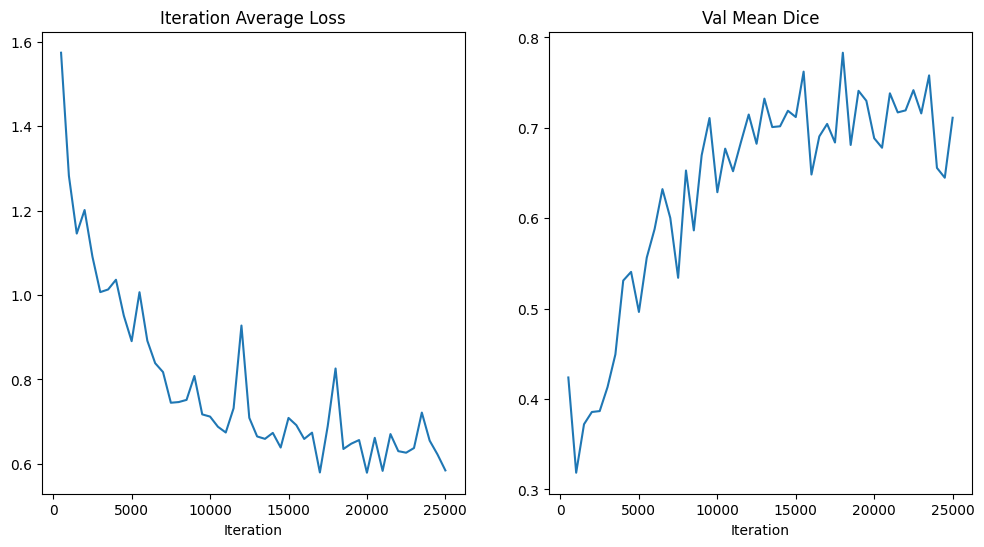

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [7]:
#test
test = torch.randn(4, 1, 96, 96, 96).cuda()
output = model(test)

x_in vit torch.Size([4, 1, 96, 96, 96])
x_in affter embed torch.Size([4, 216, 384])
torch.Size([4, 216, 384])


In [18]:
#inference MMH
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [19]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [20]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [21]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=57, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:18<00:00,  3.12it/s]


In [10]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:12<00:00,  4.65it/s]

dice_val: 0.2666066586971283


In [11]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.34900960326194763


In [12]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.02it/s]

dice_val: 0.31487661600112915


In [13]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.4232094883918762


In [14]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.95it/s]

dice_val: 0.3234732747077942


In [ ]:
#inference MMH up down flip

In [23]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503_updown_flip/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.93it/s]


In [24]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.91it/s]

dice_val: 0.2643609642982483


In [25]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.07it/s]

dice_val: 0.30316197872161865


In [26]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.32531973719596863


In [27]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.16it/s]

dice_val: 0.3863683342933655


In [28]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.08it/s]

dice_val: 0.3078237771987915
